## Analítica Indicadores vivienda JLDLC

In [2]:
import pandas as pd 
import numpy as np 
import os
from google.cloud import bigquery
from google.oauth2 import service_account
# declaramos las credenciales al entorno de desarollo
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "..\\..\\bd\\0_docs\\datahub-deacero-adojeda.json"

def Consulta_BQ(consulta):
    """ Funcion que convierte consultas tipo SQL EN PANDAS df"""
    
    client = bigquery.Client()

    query = client.query(consulta)

    df = query.to_dataframe(create_bqstorage_client=True)

    #fact.nom_estado_consignado = fact.nom_estado_consignado.replace({'DISTRITO FEDERAL': 'CIUDAD DE MEXICO'})

    #fact = fact.groupby(["mes_anio", "nom_estado_consignado"]).toneladas_facturadas.sum().unstack(-1).fillna(0)

    df.sort_index(inplace=True, ascending=True)

    return df

query_str = """SELECT 
FORMAT_DATE('%Y-%m-%d', PARSE_DATE('%B.%Y', mes_anio)) AS mes_anio,
cla_cliente_unico, 
cla_cliente,
nom_grupo_estadistico3,
sum(toneladas_facturadas) AS toneladas_facturadas
FROM `datahub-deacero.mart_comercial.comercial`
WHERE 
nom_pais_consignado = "MÉXICO"
AND nom_grupo NOT IN ('EMPRESAS RELACIONADAS','TRASPASOS E INTEREMPRESAS')
AND nom_grupo_estadistico3  NOT LIKE '%REBAR%'
AND mes_anio IS NOT NULL
AND fecha >= '2024-01-01'
GROUP BY 1,2,3,4
ORDER BY 1,2,3,4
"""

In [3]:
fact = Consulta_BQ(query_str)

count_var = "cla_cliente_unico"

fact_cliente = fact.groupby(["mes_anio", count_var]).toneladas_facturadas.sum().reset_index().sort_values(by = ["mes_anio", "toneladas_facturadas"], ascending = [True, False])

fact_cliente = fact_cliente[fact_cliente.toneladas_facturadas > 0]

fact_cliente["pp"] = fact_cliente.groupby("mes_anio").toneladas_facturadas.apply(lambda x:x.cumsum() /x.sum()).values

fact_cliente["pp"] = fact_cliente["pp"].astype(float).mul(100).round(2)

fact_cliente["toneladas_facturadas"] = fact_cliente["toneladas_facturadas"].astype(float).round(2)

fact_cliente["class"] = np.where(fact_cliente.pp<= 80, "heed_80", "tail_20")

fact_cliente[fact_cliente.mes_anio == "2024-01-01"]

fact_cliente = fact_cliente.groupby(["mes_anio","class"]).agg({count_var: "nunique", "toneladas_facturadas":"sum"}).unstack(-1).round(2)

fact_cliente.loc["tot"] = fact_cliente.mean(axis = 0)

fact_cliente

c:\Users\adojeda\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


cla_cliente_unico              toneladas_facturadas              
class                heed_80      tail_20              heed_80       tail_20
mes_anio                                                                    
2024-01-01        112.000000  1755.000000        185953.890000  46716.050000
2024-02-01        120.000000  1590.000000        126385.360000  31818.920000
2024-03-01        147.000000  1507.000000        108038.140000  27050.880000
2024-04-01        138.000000  1559.000000        154176.240000  38663.090000
2024-05-01        123.000000  1554.000000        147566.000000  37078.660000
2024-06-01         97.000000  1504.000000        145295.810000  36435.350000
2024-07-01        105.000000  1478.000000        137109.480000  34523.730000
2024-08-01        100.000000  1470.000000        156924.990000  39355.070000
2024-09-01        106.000000  1368.000000        135288.890000  33867.160000
2024-10-01        119.000000  1431.000000        140902.200000  35220.560000
2024-11-01        110.000000  1392.000000        152502.600000  38396.240000
2024-12-01        132.000000  1228.000000        109164.740000  27294.300000
2025-01-01        131.000000  1309.000000        140681.450000  35384.000000
2025-02-01        143.000000  1279.000000        124401.630000  31272.840000
2025-03-01        144.000000  1341.000000        137993.550000  34519.920000
2025-04-01        132.000000  1311.000000        134594.420000  33765.290000
2025-05-01        136.000000  1341.000000        134307.460000  33776.420000
2025-06-01        138.000000  1331.000000        130431.280000  32686.250000
2025-07-01        125.000000  1436.000000        140936.550000  35384.190000
2025-08-01        127.000000  1374.000000        146955.580000  36996.110000
2025-09-01        139.000000  1360.000000        130552.910000  32627.930000
2025-10-01        131.000000   826.000000         52218.750000  13134.810000
tot               125.227273  1397.454545        135108.269091  33907.625909

In [4]:
count_var = "nom_grupo_estadistico3"

fact_cliente = fact.groupby(["mes_anio", count_var]).toneladas_facturadas.sum().reset_index().sort_values(by = ["mes_anio", "toneladas_facturadas"], ascending = [True, False])

fact_cliente = fact_cliente[fact_cliente.toneladas_facturadas > 0]

fact_cliente["pp"] = fact_cliente.groupby("mes_anio").toneladas_facturadas.apply(lambda x:x.cumsum() /x.sum()).values

fact_cliente["pp"] = fact_cliente["pp"].astype(float).mul(100).round(2)

fact_cliente["toneladas_facturadas"] = fact_cliente["toneladas_facturadas"].astype(float).round(2)

fact_cliente["class"] = np.where(fact_cliente.pp<= 80, "heed_80", "tail_20")

fact_cliente[fact_cliente.mes_anio == "2024-01-01"]

fact_cliente = fact_cliente.groupby(["mes_anio","class"]).agg({count_var: "nunique", "toneladas_facturadas":"sum"}).unstack(-1).round(2)

fact_cliente.loc["tot"] = fact_cliente.mean(axis = 0)

fact_cliente

nom_grupo_estadistico3             toneladas_facturadas  \
class                     heed_80     tail_20              heed_80   
mes_anio                                                             
2024-01-01              20.000000  163.000000        184681.660000   
2024-02-01              22.000000  157.000000        125478.170000   
2024-03-01              22.000000  156.000000        107667.970000   
2024-04-01              20.000000  164.000000        151583.340000   
2024-05-01              21.000000  159.000000        145784.040000   
2024-06-01              20.000000  163.000000        142859.220000   
2024-07-01              22.000000  162.000000        136782.550000   
2024-08-01              18.000000  174.000000        155321.640000   
2024-09-01              20.000000  165.000000        134236.840000   
2024-10-01              20.000000  156.000000        138197.150000   
2024-11-01              19.000000  161.000000        152383.940000   
2024-12-01              20.000000  150.000000        108249.050000   
2025-01-01              21.000000  157.000000        138355.970000   
2025-02-01              21.000000  152.000000        122438.570000   
2025-03-01              20.000000  151.000000        136012.820000   
2025-04-01              19.000000  150.000000        132660.630000   
2025-05-01              20.000000  150.000000        132549.990000   
2025-06-01              20.000000  157.000000        128965.240000   
2025-07-01              21.000000  164.000000        140169.870000   
2025-08-01              20.000000  167.000000        146463.150000   
2025-09-01              21.000000  161.000000        130226.220000   
2025-10-01              18.000000  141.000000         51650.900000   
tot                     20.227273  158.181818        133759.951364   

                          
class            tail_20  
mes_anio                  
2024-01-01  46407.650000  
2024-02-01  32364.260000  
2024-03-01  27145.620000  
2024-04-01  40589.670000  
2024-05-01  37201.740000  
2024-06-01  38057.000000  
2024-07-01  34484.390000  
2024-08-01  40747.380000  
2024-09-01  34657.480000  
2024-10-01  35780.780000  
2024-11-01  38183.950000  
2024-12-01  27863.720000  
2025-01-01  34607.470000  
2025-02-01  33006.420000  
2025-03-01  36294.130000  
2025-04-01  35130.910000  
2025-05-01  35349.020000  
2025-06-01  33983.560000  
2025-07-01  35898.870000  
2025-08-01  37247.690000  
2025-09-01  32953.940000  
2025-10-01  13639.500000  
tot         34617.961364

In [5]:
count_var = "cla_cliente"

fact_cliente = fact.groupby(["mes_anio", count_var]).toneladas_facturadas.sum().reset_index().sort_values(by = ["mes_anio", "toneladas_facturadas"], ascending = [True, False])

fact_cliente = fact_cliente[fact_cliente.toneladas_facturadas > 0]

fact_cliente["pp"] = fact_cliente.groupby("mes_anio").toneladas_facturadas.apply(lambda x:x.cumsum() /x.sum()).values

fact_cliente["pp"] = fact_cliente["pp"].astype(float).mul(100).round(3)

fact_cliente["class"] = np.where(fact_cliente.pp <= 80, "first_80", "tail_20")

fact_cliente[fact_cliente.mes_anio == "2024-01-01"]

fact_cliente.groupby(["mes_anio","class"]).agg({count_var: "nunique", "toneladas_facturadas":"sum"}).unstack(-1)

cla_cliente         toneladas_facturadas                 
class         first_80 tail_20             first_80          tail_20
mes_anio                                                            
2024-01-01         196    1977     186487.180065800  46866.060389200
2024-02-01         190    1795     126540.555562300  31764.625657700
2024-03-01         211    1685     108735.000951500  27231.816498000
2024-04-01         225    1761     154700.605342600  38833.953462600
2024-05-01         199    1753     148899.078612800  37256.152505000
2024-06-01         171    1733     145759.031180000  36547.313539500
2024-07-01         182    1691     137927.678350000  34637.103460200
2024-08-01         159    1690     157630.328320000  39439.081008600
2024-09-01         158    1560     138123.365945000  34653.220217700
2024-10-01         173    1603     141377.155045900  35450.818744100
2024-11-01         163    1548     153428.438776300  38415.541687600
2024-12-01         183    1362     109634.805347900  27515.756773600
2025-01-01         188    1459     141400.845335800  35501.974559000
2025-02-01         204    1411     125184.066593300  31389.786382900
2025-03-01         207    1474     138432.635977000  34610.576230000
2025-04-01         196    1457     135244.154075500  33962.447771600
2025-05-01         203    1486     134883.421209700  33740.332054000
2025-06-01         206    1475     130804.032420000  32741.255076040
2025-07-01         188    1600     141213.687390000  35500.310475524
2025-08-01         192    1528     147200.011685500  36847.366124160
2025-09-01         208    1503     130475.636124000  32738.365264680
2025-10-01         178     902      52317.186870000  13116.713180130

In [6]:
consultas = {"varilla" : """SELECT 
FORMAT_DATE('%Y-%m-%d', PARSE_DATE('%B.%Y', mes_anio)) AS mes_anio,
nom_estado_consignado,
sum(toneladas_facturadas) AS toneladas_facturadas
FROM `datahub-deacero.mart_comercial.comercial`
WHERE 
nom_grupo_estadistico2 = "VARILLA "
AND  nom_pais_consignado = "MÉXICO"
AND nom_grupo NOT IN ('EMPRESAS RELACIONADAS','TRASPASOS E INTEREMPRESAS')
AND nom_grupo_estadistico3  NOT LIKE '%REBAR%'
AND mes_anio IS NOT NULL
GROUP BY 1,2
ORDER BY 1,2
""", 

"VARILLA_3_8": """SELECT 
FORMAT_DATE('%Y-%m-%d', PARSE_DATE('%B.%Y', mes_anio)) AS mes_anio,
nom_estado_consignado,
sum(toneladas_facturadas) AS toneladas_facturadas
FROM `datahub-deacero.mart_comercial.comercial`
WHERE nom_pais_consignado = "MÉXICO"
AND nom_grupo_estadistico3 = "VARILLA 3/8"
AND nom_grupo NOT IN ('EMPRESAS RELACIONADAS','TRASPASOS E INTEREMPRESAS')
AND mes_anio IS NOT NULL
GROUP BY 1,2
ORDER BY 1,2
""",

"negros_antaac" : """SELECT 
FORMAT_DATE('%Y-%m-%d', PARSE_DATE('%B.%Y', mes_anio)) AS mes_anio,
nom_estado_consignado,
sum(toneladas_facturadas) AS toneladas_facturadas
FROM `datahub-deacero.mart_comercial.comercial`
WHERE nom_pais_consignado = "MÉXICO"
AND nom_grupo_estadistico2 = "NEGROS ANTAAC"
AND nom_grupo NOT IN ('EMPRESAS RELACIONADAS','TRASPASOS E INTEREMPRESAS')
AND mes_anio IS NOT NULL
GROUP BY 1,2
ORDER BY 1,2
""",

"mezcla_vivenda" : """SELECT 
FORMAT_DATE('%Y-%m-%d', PARSE_DATE('%B.%Y', mes_anio)) AS mes_anio,
nom_estado_consignado,
sum(toneladas_facturadas) AS toneladas_facturadas
FROM `datahub-deacero.mart_comercial.comercial`
WHERE nom_pais_consignado = "MÉXICO"
AND clave_articulo IN ("1199", "714", "717", "720", "716", "715", "61669", "61671", "80309", "80310", "605", "603", "602", "601", "3120", "2343", "30764")
AND nom_grupo NOT IN ('EMPRESAS RELACIONADAS','TRASPASOS E INTEREMPRESAS')
AND mes_anio IS NOT NULL
GROUP BY 1,2
ORDER BY 1,2
"""
}

In [ ]:
import pandas as pd 
import numpy as np 
import os
from google.cloud import bigquery
from google.oauth2 import service_account
# declaramos las credenciales al entorno de desarollo
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "..\\..\\bd\\0_docs\\datahub-deacero-adojeda.json"

if False: 
  list_df = {}
  for key, query_str in consultas.items():
      client = bigquery.Client()
      consulta = query_str
      query = client.query(consulta)
      fact = query.to_dataframe(create_bqstorage_client=True)
      fact.nom_estado_consignado = fact.nom_estado_consignado.replace({'DISTRITO FEDERAL': 'CIUDAD DE MEXICO'})
      fact = fact.groupby(["mes_anio", "nom_estado_consignado"]).toneladas_facturadas.sum().unstack(-1).fillna(0)
      fact.sort_index(inplace=True, ascending=True)
      list_df[key] = fact

  to_replace = {'CIUDAD DE MÉXICO' :'CIUDAD DE MEXICO' ,
    'COAHUILA DE ZARAGOZA': 'COAHUILA',
    'MICHOACÁN DE OCAMPO' : 'MICHOACAN',
    'MÉXICO': 'MEXICO',
    'NUEVO LEÓN': 'NUEVO LEON',
    'QUERÉTARO': 'QUERETARO',
    'SAN LUIS POTOSÍ' : 'SAN LUIS POTOSI',
    'VERACRUZ DE IGNACIO DE LA LLAVE':'VERACRUZ',
    'YUCATÁN': 'YUCATAN'}

  ruv = pd.read_excel(r"..\RUV_v2\outputs\ruv_historico.xlsx")

  ruv.estado = ruv.estado.str.upper().replace(to_replace) 

  ruv = ruv.groupby(["fecha", "estado"]).viviendas.sum().unstack(-1) 
  
  ruv.sort_index(inplace=True, ascending=True)

  list_df["ruv"] = ruv

# Prototipo Alertas SKU PL

## 1) Árbol de decisión análisis de Datos PL SKU
El árbol genera un etiquetado de que análisis aplicar en caso de que existan las siguientes reglas de negocio

* El PL-SKU cuenta con la cantidad suficiente de Registros.
* El PL-SKU cuenta con Volumen Facturado en los últimos 6 meses previo a la fecha de cierre (Fact>0).
* El PL-SKU tiene algun valor de pronóstico (PVO/PV/BP)
* El PL-SKU cuenta con algun tipo de Deuda (Libre, mes actual o mes siguiente)

Generando los siguientes **Análisis** y **Alertas**

* Análisis de Intermitencia / Pedidos Nuevos & Bajas
* Analisis de PVO vs Deuda vs Facturación
* Alertas de Falta de Pronostico
* Alertas de Falta de Pronostico y Deuda
* Analisis de riesgo por falta de Facturación con deuda
* Alertas de Error de Pronóstico mal desagregado
* Alertas Error de Deuda no reflejada en pronostico
* Alertas de Perdida SKU PL


## Proceso Arbol Decisión Principal

### Tratamiento de datos
1) Se Genera un Híbrido SKU -GE1 -GE3 dadas las siguientes condiciones:
* GE1-GE1: PALANQUILLA
* GE1-GE3: PERFILES, SOLUCIONES, VARILLA
* GE1-GE4: ALAMBRON 
* GE1-SKU: RESTANTES



2) Agrupar la data por SUBDIR-PL SKU - MES generado los siguientes archivos de salida
* **data_** : Base de datos a nivel [SUBDIR-PL-SKU-MES] 
* **data** : Base de datos a nivel [PL-SKU-MES] 


In [7]:
import pandas as pd 
import numpy as np 
import os
from google.cloud import bigquery
from google.oauth2 import service_account
pd.set_option('display.max_columns', None)
from dateutil.relativedelta import relativedelta

# declaramos las credenciales al entorno de desarollo
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "..\\..\\bd\\0_docs\\datahub-deacero-adojeda.json"

if False: 
    # consulta SQL indicadores
    client = bigquery.Client()
    consulta = """
        WITH datos_agrupados AS (
        SELECT
            FORMAT_DATE('%Y-%m-%d', PARSE_DATE('%B.%Y', mes_anio)) AS mes_anio,
            nom_grupo AS NombreGrupo,
            nom_direccion AS NombreDireccion,
            nom_subdireccion AS NombreSubdireccion,
            nom_familia_asociada,
            nom_ubicacion,
            nom_grupo_estadistico1 AS NombreGrupoEstadistico1,
            nom_grupo_estadistico2 AS NombreGrupoEstadistico2,
            nom_grupo_estadistico3 AS NombreGrupoEstadistico3,
            nom_grupo_estadistico4 AS NombreGrupoEstadistico4,
            nom_articulo,
            SUM(toneladas_pvo) AS toneladas_pvo,
            SUM(toneladas_plan_ventas) AS toneladas_plan_ventas,
            SUM(toneladas_facturadas) AS toneladas_facturadas,
            SUM(toneladas_deuda_libre) AS toneladas_deuda_libre, 
            SUM(toneladas_deuda_mes_resto) AS toneladas_deuda_mes_resto, 
            SUM(toneladas_deuda_mes_siguiente) AS toneladas_deuda_mes_siguiente 
        FROM `datahub-deacero.mart_comercial.comercial`
        WHERE
            fecha >= '2022-01-01'
            AND fecha < '2026-01-01'
            AND nom_grupo NOT IN ('EMPRESAS RELACIONADAS','TRASPASOS E INTEREMPRESAS')
            AND nom_subdireccion NOT IN ('EXCEDENTES ACEROS','EXCEDENTES ALAMBRES','RESTO ALAMBRES','RESTO INGETEK')
            AND nom_grupo_estadistico1 NOT IN ('CHATARRA','DEACERO POWER','INTERNAS PRODUCCION ','LOGÍSTICA','SEGUNDAS')
            AND nom_grupo_estadistico2 NOT IN ('SEGUNDAS / EXCEDENTES','CHQ')
            AND nom_grupo_estadistico3 NOT IN ('DESPERDICIO','ALAMBRON SEGUNDAS','ALAMBRON EXCEDENTES','ALAMBRON TERCEROS','ALAMBRON OTROS','PILOTES','PISO','POLIZAS')
            AND nom_articulo IS NOT NULL
            AND nom_ubicacion IS NOT NULL
        GROUP BY 1,2,3,4,5,6,7,8,9,10,11
        )
        SELECT *
        FROM datos_agrupados
        ORDER BY  1,2,3,4,5,6,7,8,9,10,11
            """
    
    query = client.query(consulta)
    pvo = query.to_dataframe(create_bqstorage_client=True)
    pvo["valid_ton"] = abs(pvo["toneladas_plan_ventas"].astype(float).fillna(0) + pvo["toneladas_pvo"].astype(float).fillna(0) + pvo["toneladas_facturadas"].astype(float).fillna(0)\
          + pvo["toneladas_deuda_libre"].astype(float).fillna(0) + pvo["toneladas_deuda_mes_resto"].astype(float).fillna(0) + + pvo["toneladas_deuda_mes_siguiente"].astype(float).fillna(0))
    pvo_v = pvo[pvo["valid_ton"] != 0]
    pvo_v.to_csv(r".\consultas\base_fin.csv", index=False)

#--------------------------------------------------------------------------------------------------------------------------------------------------------------------
date_tdy = pd.to_datetime("today").normalize().replace(day = 1)

date_lm = date_tdy - relativedelta(months= 1)

date_start = date_tdy.replace(year = date_tdy.year - 3)

date_6m = date_tdy - relativedelta(months= 6)
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------

data = pd.read_csv(r".\consultas\base_fin.csv", parse_dates=["mes_anio"], engine="pyarrow")

# eliminamos volumen articulos nulos
data = data[data.nom_articulo.notna()]

# eliminamos volumen ubicacion nulos
data = data[data.nom_ubicacion.notna()]

data["mes_anio"] = pd.to_datetime(data["mes_anio"])

data = data[data["mes_anio"] >= date_start]

# aplicamos strip (eliminacion de espacios nombre ubicacion)
data.nom_ubicacion = data.nom_ubicacion.str.strip()

# mapeamos reglas de negocio para agrupar articulos 
data["nom_articulo_2"] = np.where(data["NombreGrupoEstadistico1"].str.contains("PALANQUILLA"),
                      "G1_" + data["NombreGrupoEstadistico1"] ,
                      np.where(
                          data.NombreGrupoEstadistico1.isin(["PERFILES","SOLUCIONES","VARILLA"]),
                            "G3_" +data.NombreGrupoEstadistico3,
                            np.where(data.NombreGrupoEstadistico1.isin(["ALAMBRON"]),
                                     "G4_" + data.NombreGrupoEstadistico4, 
                             "SKU_" + data.nom_articulo)))

# creamos id
data["id"] = data["nom_ubicacion"] + "_" + data["nom_articulo_2"]

# creamos catalogo id
#catalogo_id = data[["id", "nom_ubicacion","nom_articulo_2", "nom_articulo", "NombreGrupoEstadistico1", "NombreGrupoEstadistico2", "NombreGrupoEstadistico3", "NombreGrupoEstadistico4"]].drop_duplicates().copy()

data_ = data.copy()

cols2agg = ["id", "NombreGrupo", "nom_ubicacion", "nom_articulo_2", "nom_articulo", "NombreGrupoEstadistico1", "NombreGrupoEstadistico2","NombreGrupoEstadistico3", "NombreGrupoEstadistico4","nom_familia_asociada"]

data["pk"] = data[["NombreGrupo", "nom_ubicacion", "NombreGrupoEstadistico1", "NombreGrupoEstadistico2","NombreGrupoEstadistico3", "NombreGrupoEstadistico4","nom_articulo"]].apply(lambda x: "_".join(x), axis=1)

data = data.groupby(cols2agg + ["mes_anio"]).agg({"toneladas_facturadas":"sum",
                                                  "toneladas_deuda_libre":"sum",
                                                    "toneladas_deuda_mes_resto": "sum",
                                                      "toneladas_deuda_mes_siguiente": "sum",
                                                        "toneladas_plan_ventas":"sum",
                                                          "toneladas_pvo": "sum"
                                                                    }).reset_index()

data["ton_valid"] = data[["toneladas_facturadas","toneladas_deuda_libre", "toneladas_deuda_mes_resto", "toneladas_deuda_mes_siguiente", "toneladas_plan_ventas", "toneladas_pvo"]].fillna(0).sum(axis = 1)
data = data[data["ton_valid"] != 0]

3)  **MAPE & WMAPE** a nivel id (SKU_PL) mes_anio

In [8]:
# De los datos agregados a nivel SKU PL - ID se procede a calcular el mape a nivel id - Mes año
data.toneladas_facturadas = data.toneladas_facturadas.fillna(0) 

data["MAPE_PVO"] = np.where(
                        (data.toneladas_facturadas < 1) & (data.toneladas_pvo < 1), 0, 
                        np.where(
                            ((data.toneladas_facturadas < 1) & (data.toneladas_pvo >= 1)) | ((data.toneladas_facturadas >= 1) & (data.toneladas_pvo < 1)), 1,
                            np.where(
                                (data.toneladas_facturadas >= 1) & (data.toneladas_pvo >= 1),
                                np.abs(data.toneladas_facturadas - data.toneladas_pvo) / np.where(data.toneladas_pvo != 0, data.toneladas_pvo, 1),  # Evita división por cero
                                0
                            )
                        )
                    )

# TOPAMOS EL VALOR MÁXIMO A 2
data["MAPE_PVO"] = np.minimum(data["MAPE_PVO"],2)

# CREAMOS VALOR WMAPE # multiplicaccion d mape por su tonelaje 
data["WMAPE_PVO"] = np.where(data.toneladas_facturadas > 0, data.toneladas_facturadas.mul(data.MAPE_PVO), np.nan)

3) Creación de tabla nivel ID para la toma de decisiones: 
* **tiene_registros_suficientes**:  PL-SKU cuenta con la cantidad suficiente de Registros.
* **tiene_fact_6m**: El PL-SKU cuenta con Volumen Facturado en los últimos 6 meses previo a la fecha de cierre (Fact>0).
* **tiene_pronostico**: El PL-SKU tiene algun valor de pronóstico (PVO/PV/BP)
* **tiene_deuda**: El PL-SKU cuenta con algun tipo de Deuda (Libre, mes actual o mes siguiente)
* **Analisis**: Accionable para el etiquetado de la salida por SKU-PL

In [9]:
# TIENE_REGISTROS_SUFICIENTES TOTAL HISTORIA 2023 - TDY
count_registro_id = data[data.toneladas_facturadas.fillna(0) != 0 ].groupby(cols2agg).toneladas_facturadas.count().reset_index().rename(columns ={"toneladas_facturadas": "count_mcc"} )

count_registro_id["tiene_registros_suficientes"] = np.where(count_registro_id.count_mcc > 5, True, False)

# tiene_fact_6m CALCULAMOS LA ULTIMA FECHA CON FACTURACIÓN 
last_purchase = data[data.toneladas_facturadas.fillna(0) != 0 ].groupby(cols2agg).mes_anio.max()

# A LA FECHA ACTUAL SE LE RESTA LA ULTIMA FECHA CON FACTURACIÓN PARA CALCULAR MESES SIN COMPRA MSC
last_purchase = last_purchase.apply(lambda x : round((date_tdy - x).days / 30)).reset_index().rename(columns ={"mes_anio": "msc"})

# CALCULAMOS VARIABLE BOLEANA QUE PREGUNTA SI TINE MSC MENOR O IGUAL A 6
last_purchase["tiene_fact_6m"] = np.where(last_purchase.msc<=6, True, False)

# DEL MES ACTUAL SE CALCULAN LAS VARIABLES DE PRONOSTICO
last_forecast = data[data.mes_anio == date_tdy].groupby(cols2agg).agg({"toneladas_plan_ventas":"sum", "toneladas_pvo": "sum"}).reset_index()

# VARIABLE BOLEANA QUE ES SI EN CASO DE QUE EL SKU TENGA PVO O PV
last_forecast["tiene_pronostico"] = np.where((last_forecast.toneladas_plan_ventas > 0) | (last_forecast.toneladas_pvo > 0), True, False)

# CALCULO DE LA DEUDA DEL MES EN CURSO
deuda = data[data.mes_anio == date_tdy].groupby(cols2agg).agg({"toneladas_deuda_libre":"sum", "toneladas_deuda_mes_resto": "sum", "toneladas_deuda_mes_siguiente": "sum"}).reset_index()

# VARIABLE BOLEANA PARA PREGUNTAR SI SE TIENE DEUDA
deuda["tiene_deuda"] = np.where((deuda.toneladas_deuda_libre > 0) | (deuda.toneladas_deuda_mes_resto > 0) |(deuda.toneladas_deuda_mes_siguiente), True, False)

# MERGE 1 
tabla_arbol = count_registro_id.merge(last_purchase, how = "outer", on = cols2agg, validate = "1:1")

# MERGE 2
tabla_arbol = tabla_arbol.merge(last_forecast, how = "outer", on = cols2agg, validate = "1:1").sort_values(by = "count_mcc")

# MERGE 3
tabla_arbol = tabla_arbol.merge(deuda, how = "outer", on = cols2agg, validate = "1:1").sort_values(by = "count_mcc")

# reemplazamos valores null
tabla_arbol = tabla_arbol.fillna({'count_mcc': 0,
                                  'msc': 60,
                                  'toneladas_plan_ventas' : np.nan,
                                  'toneladas_pvo': np.nan,
                                  'tiene_pronostico': False,
                                  'toneladas_deuda_libre': 0,
                                  'toneladas_deuda_mes_resto': 0,
                                  'toneladas_deuda_mes_siguiente' : 0,
                                  'tiene_deuda': False,
                                  "tiene_registros_suficientes": False,
                                  "tiene_fact_6m":False
                                  }).reset_index(drop = True)

tabla_arbol.head(1)

def clasificar_pl_sku_np(df):
    condiciones = [
        ~df['tiene_registros_suficientes'], #1
        df['tiene_registros_suficientes'] & ~df['tiene_fact_6m'] & df['tiene_pronostico'] & df['tiene_deuda'], # 2
        df['tiene_registros_suficientes'] & ~df['tiene_fact_6m'] & df['tiene_pronostico'] & ~df['tiene_deuda'], # 3
        df['tiene_registros_suficientes'] & ~df['tiene_fact_6m'] & ~df['tiene_pronostico'] & df['tiene_deuda'], # 4
        df['tiene_registros_suficientes'] & ~df['tiene_fact_6m'] & ~df['tiene_pronostico'] & ~df['tiene_deuda'], # 5
        df['tiene_registros_suficientes'] & df['tiene_fact_6m'] & df['tiene_pronostico'], #6
        df['tiene_registros_suficientes'] & df['tiene_fact_6m'] & ~df['tiene_pronostico'] & df['tiene_deuda'], #7
        df['tiene_registros_suficientes'] & df['tiene_fact_6m'] & ~df['tiene_pronostico'] & ~df['tiene_deuda'], #8
    ]
    resultados = [
        "Datos Insuficientes/ Pedidos Intermitentes", #1
        "Analisis de riesgo por falta de Facturación con deuda", #2
        "Alertas de Error de Pronóstico mal desagregado", #3
        "Alertas Error de Deuda no reflejada en pronostico", #4
        "Alertas de Perdida SKU PL", #5
        "Analisis de PVO vs Deuda vs Facturación", #6
        "Alertas de Falta de Pronóstico", #7
        "Alertas de Falta de Pronóstico y Deuda" #8
    ]
    df['analisis'] = np.select(condiciones, resultados, default="Sin Clasificación")    
    df['analisis'] = df['analisis'].fillna("Sin Clasificación")
    return df

# Generamos la columna de análisis para cada pl & sku 
tabla_arbol = clasificar_pl_sku_np(tabla_arbol)

display(tabla_arbol.groupby("analisis").id.nunique())

order_tree = cols2agg + ['analisis','tiene_registros_suficientes','tiene_fact_6m','tiene_pronostico','tiene_deuda', 'msc', 'count_mcc', 'toneladas_plan_ventas', 'toneladas_pvo',  'toneladas_deuda_libre', 'toneladas_deuda_mes_resto', 'toneladas_deuda_mes_siguiente']
tabla_arbol = tabla_arbol[order_tree]
tabla_arbol.sample(5)

C:\Users\adojeda\AppData\Local\Temp\ipykernel_19120\2653488067.py:37: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tabla_arbol = tabla_arbol.fillna({'count_mcc': 0,


analisis
Alertas Error de Deuda no reflejada en pronostico           98
Alertas de Error de Pronóstico mal desagregado             524
Alertas de Falta de Pronóstico                             464
Alertas de Falta de Pronóstico y Deuda                    1287
Alertas de Perdida SKU PL                                 3464
Analisis de PVO vs Deuda vs Facturación                   5269
Analisis de riesgo por falta de Facturación con deuda       29
Datos Insuficientes/ Pedidos Intermitentes               18045
Name: id, dtype: int64

,id,NombreGrupo,nom_ubicacion,nom_articulo_2,nom_articulo,NombreGrupoEstadistico1,NombreGrupoEstadistico2,NombreGrupoEstadistico3,NombreGrupoEstadistico4,nom_familia_asociada,analisis,tiene_registros_suficientes,tiene_fact_6m,tiene_pronostico,tiene_deuda,msc,count_mcc,toneladas_plan_ventas,toneladas_pvo,toneladas_deuda_libre,toneladas_deuda_mes_resto,toneladas_deuda_mes_siguiente
11450,CEDI MERIDA_SKU_RED MOSQUITERA REFORZADA 1.05M...,ALAMBRES,CEDI MERIDA,SKU_RED MOSQUITERA REFORZADA 1.05M 30M,RED MOSQUITERA REFORZADA 1.05M 30M,MALLAS Y ALAMBRES,FERRETEROS,MALLA MOSQUITERA,MOSQUITERA REF 30M,(300 - 5300) MALLA MOSQUITERA REFORZADA,Datos Insuficientes/ Pedidos Intermitentes,False,False,False,False,27.0,2.0,NaN,NaN,0.0,0.00000,0.0
36465,"INDUSTRIAL MORELIA_SKU_CAB. GAL. ARG -A 3/16"" ...",ALAMBRES,INDUSTRIAL MORELIA,"SKU_CAB. GAL. ARG -A 3/16"" 2000M 1X7","CAB. GAL. ARG -A 3/16"" 2000M 1X7",MALLAS Y ALAMBRES,INDUSTRIAL GALV.,RETENIDAS DELGADA,"TORÓN RETENIDA 3/16""",(61) TORON GALVANIZADO,Datos Insuficientes/ Pedidos Intermitentes,False,False,True,False,60.0,0.0,2.42081,2.42081,0.0,0.00000,0.0
2380,ALAMBRES MÉXICO_SKU_ALAMBRE GALVANIZADO NOWAX ...,ALAMBRES,ALAMBRES MÉXICO,"SKU_ALAMBRE GALVANIZADO NOWAX CO 0.080"" 700KG","ALAMBRE GALVANIZADO NOWAX CO 0.080"" 700KG",MALLAS Y ALAMBRES,INDUSTRIAL GALV.,A.GALV. 1/4-14,AL. GALV. CAL. 14,(FA) - ALAMBRE GALVANIZADO VENTAS,Datos Insuficientes/ Pedidos Intermitentes,False,False,False,False,14.0,1.0,NaN,NaN,0.0,0.00000,0.0
5676,MEXICALI WCDC_SKU_PIJA AUTOTALADRABLE,ALAMBRES,MEXICALI WCDC,SKU_PIJA AUTOTALADRABLE,PIJA AUTOTALADRABLE,MALLAS Y ALAMBRES,CERCOS ESPECIALIZADOS,REJA CLASICA,ABRAZADERA Y TORNILLO REJA,(FA) - SISTEMA REJA CLASICA,Datos Insuficientes/ Pedidos Intermitentes,False,False,False,False,14.0,1.0,NaN,NaN,0.0,0.00000,0.0
19554,CEDI HOUSTON-TEXTUBE_G3_ANGULOS ESTRUCTURALES,USA,CEDI HOUSTON-TEXTUBE,G3_ANGULOS ESTRUCTURALES,"ANGLE 3"" X 3"" X 1/4"" A36/529-50 20' 2.0T",PERFILES,PERFILES ESTRUCTURALES,ANGULOS ESTRUCTURALES,"ANGULO 3""",(236) ANGULO,Datos Insuficientes/ Pedidos Intermitentes,False,True,True,True,1.0,5.0,28.65854,28.65854,0.0,9.77945,0.0


In [19]:
tabla_arbol.sum(numeric_only=True).round(1)

tiene_registros_suficientes       13359.0
tiene_fact_6m                     13220.0
tiene_pronostico                  12779.0
tiene_deuda                        6344.0
msc                              667023.0
count_mcc                        280532.0
toneladas_plan_ventas            284258.3
toneladas_pvo                    286692.6
toneladas_deuda_libre            156685.7
toneladas_deuda_mes_resto         57392.3
toneladas_deuda_mes_siguiente     69253.3
dtype: float64

In [18]:
date_tdy, date_lm, date_6m

(Timestamp('2025-10-01 00:00:00'),
 Timestamp('2025-09-01 00:00:00'),
 Timestamp('2025-04-01 00:00:00'))

In [20]:
### ------------------- Proceso anterior
def pvo_act(data_):
    #CALCULO DE TONELAJE POR DIRECCION DEL MES ANTERIOR / ACTUAL
    tonelaje_lm_dir = data_[data_.mes_anio == date_tdy].groupby(cols2agg).agg({"toneladas_plan_ventas":"sum", "toneladas_pvo": "sum"}).unstack(-1)

    tonelaje_lm_dir.columns = [(i[0].split("_")[1]+ "_MES_ACT_"+i[1]).upper()  for i in tonelaje_lm_dir.columns]

    tonelaje_lm =  data_[data_.mes_anio == date_tdy ].groupby(["id"]).agg({"toneladas_pvo":"sum"})

    tonelaje_lm.columns= [(i.split("_")[1] + "_MES_ACT__TOT").upper() for i in tonelaje_lm.columns] 

    tonelaje_lm = tonelaje_lm_dir.merge(tonelaje_lm, how = "left", left_index= True, right_index= True).sort_index(axis=1)
    
    return tonelaje_lm

#CALCULO DE TONELAJE POR DIRECCION DEL MES ANTERIOR / ACTUAL
def ton_lm(data_):
    tonelaje_lm_dir = data_[data_.mes_anio == date_lm ].groupby(["id", "NombreGrupo"]).agg({"toneladas_facturadas":"sum", "toneladas_plan_ventas":"sum"}).unstack(-1)

    tonelaje_lm_dir.columns = [(i[0].split("_")[1]+ "_mes_ant_"+i[1]).upper()  for i in tonelaje_lm_dir.columns]

    tonelaje_lm =  data_[data_.mes_anio == date_lm ].groupby(["id"]).agg({"toneladas_facturadas":"sum", "toneladas_pvo":"sum"})

    tonelaje_lm.columns= [(i.split("_")[1] + "_mes_ant__tot").upper() for i in tonelaje_lm.columns] 

    tonelaje_lm = tonelaje_lm_dir.merge(tonelaje_lm, how = "left", left_index= True, right_index= True).sort_index(axis=1)

    return tonelaje_lm


#CALCULO DE INDICADORES 6M
def ton_med_6m(data_):
    # AGRUPAMOS POR MES ID SUMAMOS Y CONTAMOS
    tonelaje_lm_dir = data_[(data_.mes_anio >= date_6m) & (data_.mes_anio < date_tdy)  ].groupby(["id", "mes_anio"]).agg({"toneladas_facturadas":"sum", "toneladas_pvo":"sum"}).reset_index()
    
    tonelaje_lm_dir = tonelaje_lm_dir.sort_values(by = "mes_anio")

    tonelaje_lm_dir = tonelaje_lm_dir.groupby("id").agg({"toneladas_facturadas":["sum","mean", "std"], "toneladas_pvo":["sum","mean", "std"] ,"mes_anio": ["unique", "nunique"]})

    tonelaje_lm_dir.columns = [(i[0].split("_")[1]+ "_6m_"+i[1]).upper()  for i in tonelaje_lm_dir.columns]

    tonelaje_lm_dir["ANIO_6M_UNIQUE"] = tonelaje_lm_dir["ANIO_6M_UNIQUE"].apply(lambda x: [str(i)[2:7] for i in x])

    return tonelaje_lm_dir

#ton_pvo_act = pvo_act(data_)
#ton_pvo_lm = ton_lm(data_)
#ton_6m = ton_med_6m(data_)
#toneladas_lm_act = ton_pvo_act.merge(ton_pvo_lm, how= "outer", left_index= True, right_index= True, validate= "1:1")
#toneladas_lm_act = toneladas_lm_act.merge(ton_6m, how= "outer", left_index= True, right_index= True, validate= "1:1").reset_index()

### ------------------- Proceso nuevo 

def pvo_pv_ant_act(data_):
    aggf = {"toneladas_plan_ventas":"sum", "toneladas_pvo": "sum", "toneladas_facturadas":"sum"}
    aggf_6m = {"toneladas_plan_ventas":"mean", "toneladas_pvo": "mean", "toneladas_facturadas":"mean"}
    aggf_6m_std = {"toneladas_plan_ventas":"std", "toneladas_pvo": "std", "toneladas_facturadas":"std"}
    
    tonelaje_act = data_[data_.mes_anio == date_tdy].groupby(cols2agg).agg(aggf).rename(columns = {"toneladas_plan_ventas":"ton_pv_mes_act",
                                                                                                    "toneladas_pvo": "ton_pvo_mes_act",
                                                                                                      "toneladas_facturadas" : "ton_fact_mes_act"}).reset_index()
    
    tonelaje_ant = data_[data_.mes_anio == date_lm ].groupby(cols2agg).agg(aggf).rename(columns = {"toneladas_plan_ventas":"ton_pv_mes_ant",
                                                                                                    "toneladas_pvo": "ton_pvo_mes_ant", 
                                                                                                    "toneladas_facturadas" : "ton_fact_mes_ant"}).reset_index()

    tonelaje_6m = data_[(data_.mes_anio >= date_6m) & (data_.mes_anio < date_tdy)].groupby(cols2agg).agg(aggf_6m).rename(columns = {"toneladas_plan_ventas":"ton_pv_mes_6m",
                                                                                                                                     "toneladas_pvo": "ton_pvo_mes_6m",
                                                                                                                                     "toneladas_facturadas" : "ton_fact_mes_6m" }).reset_index()

    tonelaje_6m_std = data_[(data_.mes_anio >= date_6m) & (data_.mes_anio < date_tdy)].groupby(cols2agg).agg(aggf_6m_std).rename(columns = {"toneladas_plan_ventas":"ton_pv_mes_6m_std",
                                                                                                                                     "toneladas_pvo": "ton_pvo_mes_6m_std",
                                                                                                                                     "toneladas_facturadas" : "ton_fact_mes_6m_std" }).reset_index()

    out = tonelaje_act.merge(tonelaje_ant, how = "outer", on = cols2agg, validate = "1:1")
    out_6m = tonelaje_6m.merge(tonelaje_6m_std, how = "outer", on = cols2agg, validate = "1:1")
    out = out.merge(out_6m, how = "outer", on = cols2agg, validate = "1:1")
    
    return out

In [21]:
# tabla_arbol = tabla_arbol.merge(toneladas_lm_act, how = "left", on ="id", validate= "1:1" )

tabla_arbol = tabla_arbol.merge(pvo_pv_ant_act(data_), how = "left", on =cols2agg, validate= "1:1" )

tabla_arbol

,id,NombreGrupo,nom_ubicacion,nom_articulo_2,nom_articulo,NombreGrupoEstadistico1,NombreGrupoEstadistico2,NombreGrupoEstadistico3,NombreGrupoEstadistico4,nom_familia_asociada,analisis,tiene_registros_suficientes,tiene_fact_6m,tiene_pronostico,tiene_deuda,msc,count_mcc,toneladas_plan_ventas,toneladas_pvo,toneladas_deuda_libre,toneladas_deuda_mes_resto,toneladas_deuda_mes_siguiente,ton_pv_mes_act,ton_pvo_mes_act,ton_fact_mes_act,ton_pv_mes_ant,ton_pvo_mes_ant,ton_fact_mes_ant,ton_pv_mes_6m,ton_pvo_mes_6m,ton_fact_mes_6m,ton_pv_mes_6m_std,ton_pvo_mes_6m_std,ton_fact_mes_6m_std
0,ACERÍA CELAYA_G3_VARILLA 1,DEACERO SOLUTIONS,ACERÍA CELAYA,G3_VARILLA 1,"VARILLA DA- 506 G42 C5 1"" 9.0M P45 R INGETEK",VARILLA,VARILLA,VARILLA 1,VARILLA 1 RECTA,(57) VARILLA LAM CALIENTE,Datos Insuficientes/ Pedidos Intermitentes,False,False,False,False,33.0,1.0,NaN,NaN,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ACERÍA CELAYA_G3_VARILLA 3/4,ALAMBRES,ACERÍA CELAYA,G3_VARILLA 3/4,"VARILLA DA- 506 G42 C5 3/4"" 12.0 M P41 R INGET...",VARILLA,VARILLA,VARILLA 3/4,VARILLLA 3/4 RECTA,(57) VARILLA LAM CALIENTE,Datos Insuficientes/ Pedidos Intermitentes,False,False,False,False,37.0,1.0,NaN,NaN,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,WEST MEMPHIS DC._G3_ANGULOS ESTRUCTURALES,USA,WEST MEMPHIS DC.,G3_ANGULOS ESTRUCTURALES,"ANGLE 5"" X 5"" X 5/16"" A36/529-50 20' 2.0T",PERFILES,PERFILES ESTRUCTURALES,ANGULOS ESTRUCTURALES,"ANGULO 5""",(236) ANGULO,Datos Insuficientes/ Pedidos Intermitentes,False,False,False,False,26.0,1.0,NaN,NaN,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ACERÍA CELAYA_G3_VARILLA 1/2,ACEROS,ACERÍA CELAYA,G3_VARILLA 1/2,"VARILLA DA- 506 G42 C2 1/2"" 12.0 M P02 R",VARILLA,VARILLA,VARILLA 1/2,VARILLA 1/2 RECTA,(57) VARILLA LAM CALIENTE,Datos Insuficientes/ Pedidos Intermitentes,False,False,False,False,33.0,1.0,NaN,NaN,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.509807,2.691963,NaN,1.290545,1.60605,NaN
4,ACERÍA CELAYA_G3_VARILLA 1/2,ALAMBRES,ACERÍA CELAYA,G3_VARILLA 1/2,"VARILLA DA- 506 G42 C1 1/2"" 10.60 M P92 R",VARILLA,VARILLA,VARILLA 1/2,VARILLA 1/2 RECTA,(57) VARILLA LAM CALIENTE,Datos Insuficientes/ Pedidos Intermitentes,False,False,False,False,25.0,1.0,NaN,NaN,0.000000,0.0,0.0,NaN,NaN,NaN,0.39474,0.39474,0.0,0.394740,0.394740,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37514,UNIDADES DE SERVICIO_SKU_GRAPA NACIONAL (10 M)...,ALAMBRES,UNIDADES DE SERVICIO,"SKU_GRAPA NACIONAL (10 M) N 16 1 1/2""","GRAPA NACIONAL (10 M) N 16 1 1/2""",MALLAS Y ALAMBRES,INDUSTRIAL FASTENERS,GRAPA P/MADERA,GRAPA P/CASCO NACIONAL,(4900 - 2939) GRAPA P/CASCO GS CAL16 PASLODE,Datos Insuficientes/ Pedidos Intermitentes,False,False,True,False,60.0,0.0,0.00214,0.00214,0.000000,0.0,0.0,0.00214,0.00214,0.0,0.01231,0.01231,0.0,0.012310,0.012310,NaN,NaN,NaN,NaN
37515,UNIDADES DE SERVICIO_SKU_GRAPA NACIONAL DEACER...,ALAMBRES,UNIDADES DE SERVICIO,"SKU_GRAPA NACIONAL DEACERO GS 16 1 3/4""","GRAPA NACIONAL DEACERO GS 16 1 3/4""",MALLAS Y ALAMBRES,INDUSTRIAL FASTENERS,GRAPA P/MADERA,GRAPA P/CASCO NACIONAL,(4900 - 2939) GRAPA P/CASCO GS CAL16 PASLODE,Datos Insuficientes/ Pedidos Intermitentes,False,False,True,False,60.0,0.0,0.00303,0.00303,0.000000,0.0,0.0,0.00303,0.00303,0.0,0.01744,0.01744,0.0,0.017440,0.017440,NaN,NaN,NaN,NaN
37516,VIRTUAL AZZ SAN ANTONIO_G3_GALVANIZED FAB. BAR...,DEACERO SOLUTIONS,VIRTUAL AZZ SAN ANTONIO,G3_GALVANIZED FAB. BARS & BEAMS,"GALVANIZED SOLAR PIERS 6"" X 12.0 A992/572-50 1...",SOLUCIONES,PERFILES HABILITADOS,GALVANIZED FAB. BARS & BEAMS,GALVANIZED FABRICATED BEAMS,(499) PERFIL HABILITADO ITK,Datos Insuficientes/ Pedidos Intermitentes,False,False,False,True,60.0,0.0,0.00000,0.00000,35.380280,0.0,0.0,0.00000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37517,VIRTUAL AZZ SAN ANTONIO_G3_GALVANIZED FAB. BAR...,DEACERO SOLUTIONS,VIRTUAL AZZ SAN ANTONIO,G3_GALVANIZED FAB. BARS

In [23]:
tabla_arbol.sum(numeric_only=True).round(1)

tiene_registros_suficientes       13359.0
tiene_fact_6m                     13220.0
tiene_pronostico                  12779.0
tiene_deuda                        6344.0
msc                              667023.0
count_mcc                        280532.0
toneladas_plan_ventas            284258.3
toneladas_pvo                    286692.6
toneladas_deuda_libre            156685.7
toneladas_deuda_mes_resto         57392.3
toneladas_deuda_mes_siguiente     69253.3
ton_pv_mes_act                   284258.3
ton_pvo_mes_act                  286692.6
ton_fact_mes_act                 126521.3
ton_pv_mes_ant                   253814.8
ton_pvo_mes_ant                  247759.0
ton_fact_mes_ant                 217750.4
ton_pv_mes_6m                    241684.6
ton_pvo_mes_6m                   246820.8
ton_fact_mes_6m                  284496.2
ton_pv_mes_6m_std                132731.8
ton_pvo_mes_6m_std               138559.3
ton_fact_mes_6m_std              161807.8
dtype: float64

4) Calculos de Indicadores Clave por Grupo 

In [26]:
# CALCULO DE MAPE PROMEDIO POR ID ULTIMOS 6M ANTES DE CORTE primero promediar por mes enseguida por grupo 
# RECORDEMOS QUE EN ESTE CONJUNTO DE DATA SE ELIMINARON COMBINACIONES SIN FACTURACION EN LOS ULTIMOS 6 MESES?
# no se han imputado 0s / EN EL MAPE PROMEDIO POR SKU NO EXISTE SI NO TENEMOS FACTURACION NI PRONOSTICO... 
# LA CANTIDAD DE DATOS POR VENTANA VA A VARIAR 

mape = data[(data.mes_anio >= date_6m) & (data.mes_anio< date_tdy)][["id","mes_anio","MAPE_PVO", "WMAPE_PVO", "toneladas_facturadas"]]
  
#mape.groupby(["id"]).toneladas_facturadas.count().value_counts(normalize=True).plot(kind = "bar")

mape["analisis"] = mape.id.map(tabla_arbol.groupby("id").analisis.last().to_dict()).fillna("NA")

resultados_6m_map = mape.groupby(["analisis","mes_anio"]).agg({"MAPE_PVO":"mean", "WMAPE_PVO": "sum", "toneladas_facturadas": "sum", "id": "nunique"}).reset_index().groupby("analisis").mean().drop(columns = "mes_anio")

resultados_6m_map["WMAPE_PVO"] = resultados_6m_map["WMAPE_PVO"].div(resultados_6m_map.toneladas_facturadas)

resultados_6m_map = resultados_6m_map.rename(columns={"toneladas_facturadas":"fact_acomulada", "id":"ids_w_mape"})

resultados_6m_map["fact_acomulada"] = resultados_6m_map["fact_acomulada"].round(2)

resultados_6m_map ["pp"] = resultados_6m_map["fact_acomulada"].div(resultados_6m_map["fact_acomulada"].sum()).mul(100)

out = tabla_arbol.groupby("analisis").agg({"id": "nunique",
                                              "toneladas_deuda_libre":"sum",
                                                "toneladas_deuda_mes_resto": "sum",
                                                  "toneladas_deuda_mes_siguiente": "sum",
                                                    "toneladas_plan_ventas":"sum",
                                                      "toneladas_pvo": "sum"})

out = out.merge(resultados_6m_map, how = "left", left_index=True, right_index=True).sort_values(by = "fact_acomulada", ascending=False).round(2)

out.loc["total",:] = out.sum(axis = 0)

out.fillna("-")

,id,toneladas_deuda_libre,toneladas_deuda_mes_resto,toneladas_deuda_mes_siguiente,toneladas_plan_ventas,toneladas_pvo,MAPE_PVO,WMAPE_PVO,fact_acomulada,ids_w_mape,pp
analisis,,,,,,,,,,,
Analisis de PVO vs Deuda vs Facturación,5269.0,83797.14,43886.78,45714.29,230472.39,232196.95,0.52,0.74,128078.57,4897.33,57.47
Datos Insuficientes/ Pedidos Intermitentes,18045.0,66817.81,9932.78,19925.46,52406.06,53113.98,0.44,0.95,79020.97,3285.67,35.46
Alertas de Falta de Pronóstico,464.0,5370.28,3323.34,3485.84,0.00,0.00,0.63,1.08,6940.62,257.17,3.11
Alertas de Falta de Pronóstico y Deuda,1287.0,0.00,0.00,0.00,0.00,0.00,0.55,1.1,6301.18,625.17,2.83
Alertas de Perdida SKU PL,3464.0,0.00,0.00,0.00,0.00,0.00,0.35,1.05,2496.47,391.83,1.12
Alertas Error de Deuda no reflejada en pronostico,98.0,570.19,209.32,103.03,0.00,0.00,0.49,1.0,17.03,18.17,0.01
Alertas de Error de Pronóstico mal desagregado,524.0,0.00,0.00,0.00,1348.85,1350.53,0.27,1.93,4.10,175.33,0.00
Analisis de riesgo por falta de Facturación con deuda,29.0,130.30,40.06,24.65,31.02,31.09,0.43,-,0.00,13.67,0.00
total,29180.0,156685.72,57392.28,69253.27,284258.32,286692.55,3.68,7.85,222858.94,9664.34,100.00


### 1) Análisis de PVO vs Deuda vs Fact

las condiciones para entrar a este analisis son las siguientes : 
* son SKU-PL que tienen registros suficientes (+6)
* Tienen almenos 1 facturación en los ultimos 6m
* Cuentan con pronostico de venta

en total son 6.0K Indicadores los cuales se analizan para

1) Encontrar aquellos que sean propensos a tener errores en Deuda/PVO
2) Analisis de Clustering para encontrar aquellos productos/SKUs que se comporten como series de tiempo
3) Otros

<Axes: xlabel='count_mcc'>

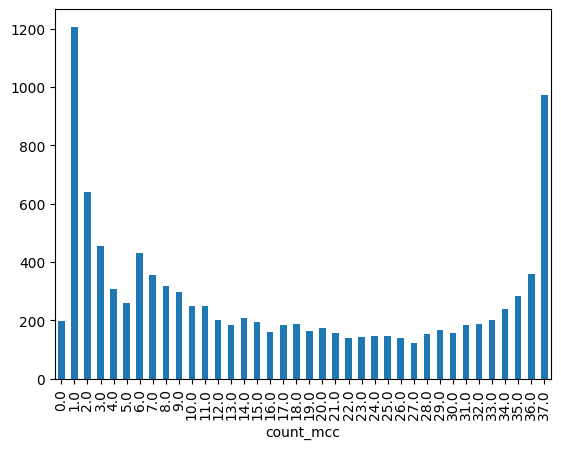

In [36]:
# distribución de OBSERVACIONES
id_a1 = tabla_arbol[tabla_arbol.analisis == "Analisis de PVO vs Deuda vs Facturación"].id.unique()  

# vista 1 barplot
tabla_arbol[tabla_arbol.id.isin(id_a1)].count_mcc.value_counts().sort_index().plot(kind= "bar")

<Axes: xlabel='mes_anio'>

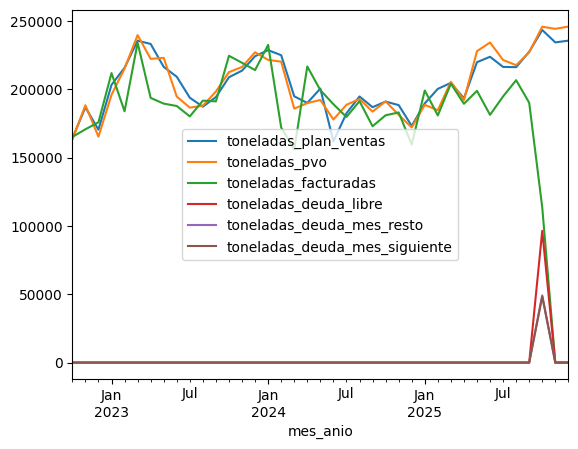

In [37]:
# comparacion de volumen
data[data.id.isin(id_a1)].groupby("mes_anio").agg({"toneladas_plan_ventas":"sum", "toneladas_pvo" :"sum", "toneladas_facturadas":"sum", "toneladas_deuda_libre":"sum", "toneladas_deuda_mes_resto": "sum", "toneladas_deuda_mes_siguiente": "sum"}).plot()

In [40]:
import pandas as pd

# Cargar tus datos
df = data_[data_.id.isin(id_a1)].groupby(["mes_anio", "id"]).toneladas_facturadas.sum().reset_index()  # Asegúrate de tener las columnas: id, mes_anio, toneladas_facturadas

df = df[df['toneladas_facturadas'] > 0]  # Filtrar solo las filas con toneladas_facturadas > 0

comb_tot = df.id.nunique()

print("total de combinaciones de PL & SKU :{}".format(comb_tot))

# Convertir mes_anio a formato de fecha
df['mes_anio'] = pd.to_datetime(df['mes_anio'], format='%Y-%m')

df = df.loc[df["mes_anio"] < date_tdy, :]  # Filtrar por fecha si es necesario

print(df.mes_anio.max())

# Crear todas las combinaciones posibles de id y mes_anio
ids = df['id'].unique()

# imputar ceros
meses = pd.date_range(start=df['mes_anio'].min(), end=df['mes_anio'].max(), freq='MS')

# crar combinacion mes id para colocar datos.
combinaciones = pd.MultiIndex.from_product([ids, meses], names=['id', 'mes_anio'])

# Reindexar y rellenar con 0 donde no haya facturación
df_completo = df.set_index(['id', 'mes_anio']).reindex(combinaciones, fill_value=0).reset_index()

total de combinaciones de PL & SKU :5269
2025-09-01 00:00:00


In [41]:
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters 

settings = ComprehensiveFCParameters()


# Definir parámetros personalizados para tsfresh


selected_features = {
    'linear_trend': [ {'attr': 'pvalue'}, {'attr': 'slope'}], #{'attr': 'intercept'}
    'autocorrelation': [{'lag': i} for i in range(0, 13)],
    'fft_coefficient': [{'coeff': i, 'attr': 'abs'} for i in range(0, 18)],
    'standard_deviation': None,
    'approximate_entropy': [{'m': 2, 'r': 0.2}],
    'skewness': None,
    'kurtosis': None,
    'augmented_dickey_fuller': [{'attr': 'pvalue'}],
    'binned_entropy': [{'max_bins': 12}],
    'cid_ce': [{'normalize': True}],
    #'length': None,
    'count_above_mean': None,
    #'count_below_mean': None,
    'number_peaks': [{'n': 5}],
    'variation_coefficient': None,
    'value_count': [{'value': 0}]  # Conteo explícito de ceros
    }

X = extract_features(df_completo.iloc[:,:3], 
                     column_id='id', 
                     column_sort='mes_anio',
                     default_fc_parameters=selected_features,
                     # we impute = remove all NaN features automatically
                     impute_function=impute)

print(X.shape)

# Eliminamos columnas con valores unicos ["repetidos entre todas las series"]
X = X.drop(columns = X.columns[X.apply(lambda x: x.nunique())== 1].values)

print(X.shape)

Feature Extraction: 100%|██████████| 20/20 [00:13<00:00,  1.47it/s]


(5269, 44)
(5269, 44)


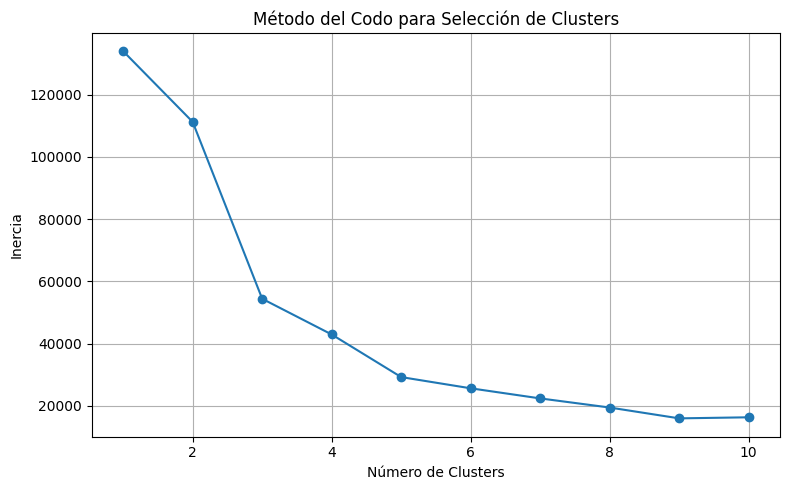

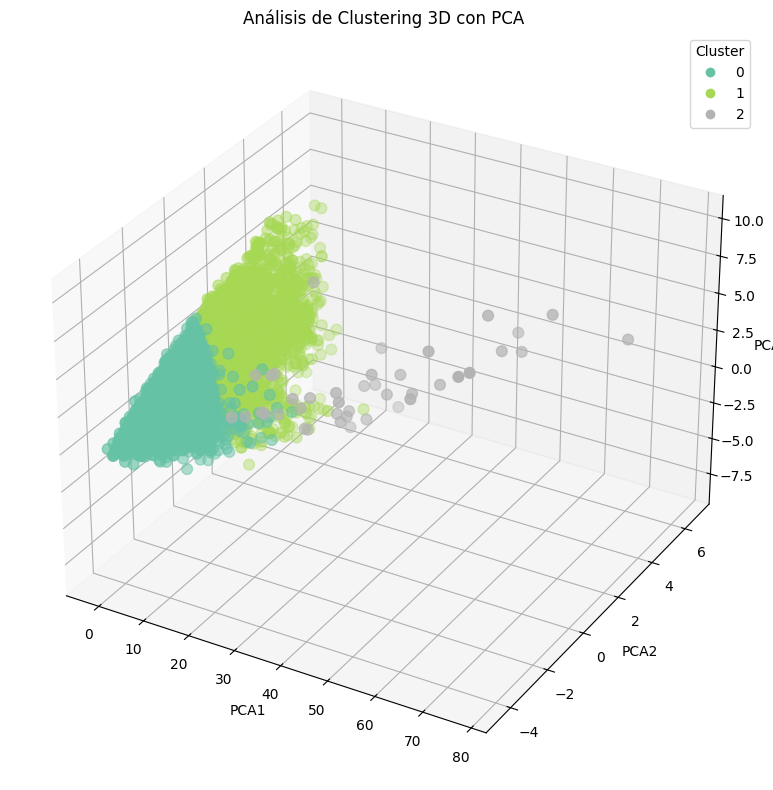

'\nprint("Ranking de variables más importantes para el clustering:")\nfor i, (feature, score) in enumerate(sorted_features[:11], 1):\n    print(f"{i}. {feature} \t  (F-score:{score:.2f})")\n    sns.violinplot(data = X, y = feature, x = "Cluster" , hue ="Cluster" )\n    display(X.groupby("Cluster")[feature].describe())\n    plt.show()\n    '

In [42]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Escalar los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

# Aplicar PCA con 4 componentes
pca = PCA(n_components=3)
pca_components = pca.fit_transform(scaled_data)

# Método del codo para determinar el número óptimo de clusters
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_components)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Método del Codo para Selección de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.grid(True)
plt.tight_layout()
plt.savefig("metodo_del_codo.png")

# Aplicar KMeans con 3 clusters como ejemplo
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(pca_components)

# Agregar componentes PCA y etiquetas de cluster al DataFrame
X['PCA1'] = pca_components[:, 0]
X['PCA2'] = pca_components[:, 1]
X['PCA3'] = pca_components[:, 2]
X['Cluster'] = clusters

# Gráfico 3D de dispersión
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X['PCA1'], X['PCA2'], X['PCA3'],
                     c=X['Cluster'], cmap='Set2', s=60)
ax.set_title('Análisis de Clustering 3D con PCA')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.tight_layout()
#plt.savefig("clustering_3d.png")
plt.show()

from scipy.stats import f_oneway


# Evaluar importancia de variables usando ANOVA (F-test)
feature_scores = {}
for col in X.columns[:-4]:  # Excluir la columna de clúster
    groups = [group[col].values for name, group in X.groupby('Cluster')]
    f_stat, p_val = f_oneway(*groups)
    feature_scores[col] = f_stat

# Ordenar las variables por importancia (F-score descendente)
sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)

# Mostrar resultados
"""
print("Ranking de variables más importantes para el clustering:")
for i, (feature, score) in enumerate(sorted_features[:11], 1):
    print(f"{i}. {feature} \t  (F-score:{score:.2f})")
    sns.violinplot(data = X, y = feature, x = "Cluster" , hue ="Cluster" )
    display(X.groupby("Cluster")[feature].describe())
    plt.show()
    """

In [44]:
# Mostrar resultados
print("Ranking de variables más importantes para el clustering:")
for i, (feature, score) in enumerate(sorted_features[:11], 1):
    print(f"{i}. {feature} \t  (F-score:{score:.2f})")
    #sns.violinplot(data = X, y = feature, x = "Cluster" , hue ="Cluster" )
    #display(X.groupby("Cluster")[feature].describe())
    plt.show()

Ranking de variables más importantes para el clustering:
1. toneladas_facturadas__standard_deviation 	  (F-score:6505.30)
2. toneladas_facturadas__fft_coefficient__attr_"abs"__coeff_14 	  (F-score:4880.26)
3. toneladas_facturadas__fft_coefficient__attr_"abs"__coeff_9 	  (F-score:4611.88)
4. toneladas_facturadas__fft_coefficient__attr_"abs"__coeff_13 	  (F-score:4541.83)
5. toneladas_facturadas__fft_coefficient__attr_"abs"__coeff_0 	  (F-score:4498.57)
6. toneladas_facturadas__fft_coefficient__attr_"abs"__coeff_7 	  (F-score:4496.90)
7. toneladas_facturadas__fft_coefficient__attr_"abs"__coeff_16 	  (F-score:4060.18)
8. toneladas_facturadas__fft_coefficient__attr_"abs"__coeff_6 	  (F-score:3994.45)
9. toneladas_facturadas__fft_coefficient__attr_"abs"__coeff_12 	  (F-score:3832.05)
10. toneladas_facturadas__fft_coefficient__attr_"abs"__coeff_10 	  (F-score:3641.29)
11. toneladas_facturadas__fft_coefficient__attr_"abs"__coeff_3 	  (F-score:3540.24)


In [46]:
analisis1 = data[data.id.isin(X.index)].copy()
"""
analisis1["MAPE_PVO"] = np.where(
                        (analisis1.toneladas_facturadas < 1) & (analisis1.toneladas_pvo < 1), 0,
                        np.where(
                            ((analisis1.toneladas_facturadas < 1) & (analisis1.toneladas_pvo >= 1)) | ((analisis1.toneladas_facturadas >= 1) & (analisis1.toneladas_pvo < 1)), 1,
                            np.where(
                                (analisis1.toneladas_facturadas >= 1) & (analisis1.toneladas_pvo >= 1),
                                np.abs(analisis1.toneladas_facturadas - analisis1.toneladas_pvo) / np.where(analisis1.toneladas_pvo != 0, analisis1.toneladas_pvo, 1),  # Evita división por cero
                                0
                            )
                        )
                    )

"""
#analisis1["MAPE_PVO"] = np.minimum(analisis1["MAPE_PVO"],2)

analisis1 = analisis1[analisis1.mes_anio < date_tdy]

analisis1["Cluster"] = analisis1.id.map(X.Cluster.to_dict())

# Asignamos cluster a arbol
tabla_arbol["CLUSTER"] =  tabla_arbol["id"].map( analisis1.set_index("id").Cluster.to_dict()).fillna(4)

data["CLUSTER"] =  data["id"].map( analisis1.set_index("id").Cluster.to_dict()).fillna(4)

data["ANALISIS"] =  data["id"].map( tabla_arbol.set_index("id").analisis.to_dict()).fillna(4)

analisis1["mcc"] = np.where(analisis1.toneladas_facturadas> 0.001, 1, 0)

analisis1

,id,NombreGrupo,nom_ubicacion,nom_articulo_2,nom_articulo,NombreGrupoEstadistico1,NombreGrupoEstadistico2,NombreGrupoEstadistico3,NombreGrupoEstadistico4,nom_familia_asociada,mes_anio,toneladas_facturadas,toneladas_deuda_libre,toneladas_deuda_mes_resto,toneladas_deuda_mes_siguiente,toneladas_plan_ventas,toneladas_pvo,ton_valid,MAPE_PVO,WMAPE_PVO,CLUSTER,ANALISIS,Cluster,mcc
1840,ACERÍA CELAYA_G3_COIL REBAR,ACEROS,ACERÍA CELAYA,G3_COIL REBAR,"VARILLA DA- 506 G42 C1 1/2"" 1.4T C",VARILLA,VARILLA ROLLO,COIL REBAR,"COIL REBAR 1/2""",(57) VARILLA LAM CALIENTE,2023-01-01,15.559,0.0,0.0,0.0,0.00000,0.00000,15.55900,1.0,15.559,1.0,Analisis de PVO vs Deuda vs Facturación,1,1
1841,ACERÍA CELAYA_G3_COIL REBAR,ACEROS,ACERÍA CELAYA,G3_COIL REBAR,"VARILLA DA- 506 G42 C1 1/2"" 1.4T C",VARILLA,VARILLA ROLLO,COIL REBAR,"COIL REBAR 1/2""",(57) VARILLA LAM CALIENTE,2023-02-01,28.410,0.0,0.0,0.0,0.00000,0.00000,28.41000,1.0,28.410,1.0,Analisis de PVO vs Deuda vs Facturación,1,1
1842,ACERÍA CELAYA_G3_COIL REBAR,ACEROS,ACERÍA CELAYA,G3_COIL REBAR,"VARILLA DA- 506 G42 C1 1/2"" 1.4T C",VARILLA,VARILLA ROLLO,COIL REBAR,"COIL REBAR 1/2""",(57) VARILLA LAM CALIENTE,2023-03-01,0.000,0.0,0.0,0.0,16.17011,12.11450,28.28461,1.0,NaN,1.0,Analisis de PVO vs Deuda vs Facturación,1,0
1843,ACERÍA CELAYA_G3_COIL REBAR,ACEROS,ACERÍA CELAYA,G3_COIL REBAR,"VARILLA DA- 506 G42 C1 1/2"" 1.4T C",VARILLA,VARILLA ROLLO,COIL REBAR,"COIL REBAR 1/2""",(57) VARILLA LAM CALIENTE,2023-09-01,32.960,0.0,0.0,0.0,4.38550,4.38550,41.73100,2.0,65.920,1.0,Analisis de PVO vs Deuda vs Facturación,1,1
1844,ACERÍA CELAYA_G3_COIL REBAR,ACEROS,ACERÍA CELAYA,G3_COIL REBAR,"VARILLA DA- 506 G42 C1 1/2"" 1.4T C",VARILLA,VARILLA ROLLO,COIL REBAR,"COIL REBAR 1/2""",(57) VARILLA LAM CALIENTE,2023-11-01,0.000,0.0,0.0,0.0,21.79136,21.79136,43.58272,1.0,NaN,1.0,Analisis de PVO vs Deuda vs Facturación,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703816,VIRTUAL V&S COLUMBUS_G3_GALVANIZED FAB. BARS &...,DEACERO SOLUTIONS,VIRTUAL V&S COLUMBUS,G3_GALVANIZED FAB. BARS & BEAMS,"GALVANIZED SOLAR PIERS 6"" X 25.0 A992/572-50 3...",SOLUCIONES,PERFILES HABILITADOS,GALVANIZED FAB. BARS & BEAMS,GALVANIZED FABRICATED BEAMS,(499) PERFIL HABILITADO ITK,2025-08-01,17.009,0.0,0.0,0.0,0.00000,0.00000,17.00900,1.0,17.009,1.0,Analisis de PVO vs Deuda vs Facturación,1,1
703820,VIRTUAL V&S COLUMBUS_G3_GALVANIZED FAB. BARS &...,DEACERO SOLUTIONS,VIRTUAL V&S COLUMBUS,G3_GALVANIZED FAB. BARS & BEAMS,"GALVANIZED SOLAR PIERS 6"" X 25.0 A992/572-50 3...",SOLUCIONES,PERFILES HABILITADOS,GALVANIZED FAB. BARS & BEAMS,GALVANIZED FABRICATED BEAMS,(499) PERFIL HABILITADO ITK,2025-08-01,39.689,0.0,0.0,0.0,0.00000,0.00000,39.68900,1.0,39.689,1.0,Analisis de PVO vs Deuda vs Facturación,1,1
703821,VIRTUAL V&S COLUMBUS_G3_GALVANIZED FAB. BARS &...,DEACERO SOLUTIONS,VIRTUAL V&S COLUMBUS,G3_GALVANIZED FAB. BARS & BEAMS,"GALVANIZED SOLAR PIERS 6"" X 25.0 A992/572-50 3...",SOLUCIONES,PERFILES HABILITADOS,GALVANIZED FAB. BARS & BEAMS,GALVANIZED FABRICATED BEAMS,(499) PERFIL HABILITADO ITK,2025-09-01,2.835,0.0,0.0,0.0,0.00000,0.00000,2.83500,1.0,2.835,1.0,Analisis de PVO vs Deuda vs Facturación,1,1
703825,VIRTUAL V&S COLUMBUS_G3_GALVANIZED FAB. BARS &...,DEACERO SOLUTIONS,VIRTUAL V&S COLUMBUS,G3_GALVANIZED FAB. BARS & BEAMS,"GALVANIZED SOLAR PIERS 8"" 31LB/PIE A992/572-50...",SOLUCIONES,PERFILES HABILITADOS,GALVANIZED FAB. BARS & BEAMS,GALVANIZED FABRICATED BEAMS,(499) PERFIL HABILITADO ITK,2025-07-01,20.248,0.0,0.0,0.0,0.00000,0.00000,20.24800,1.0,20.248,1.0,Analisis de PVO vs Deuda vs Facturación,1,1


Gráfico guardado como 'kpi_cluster_grid_extended.png'


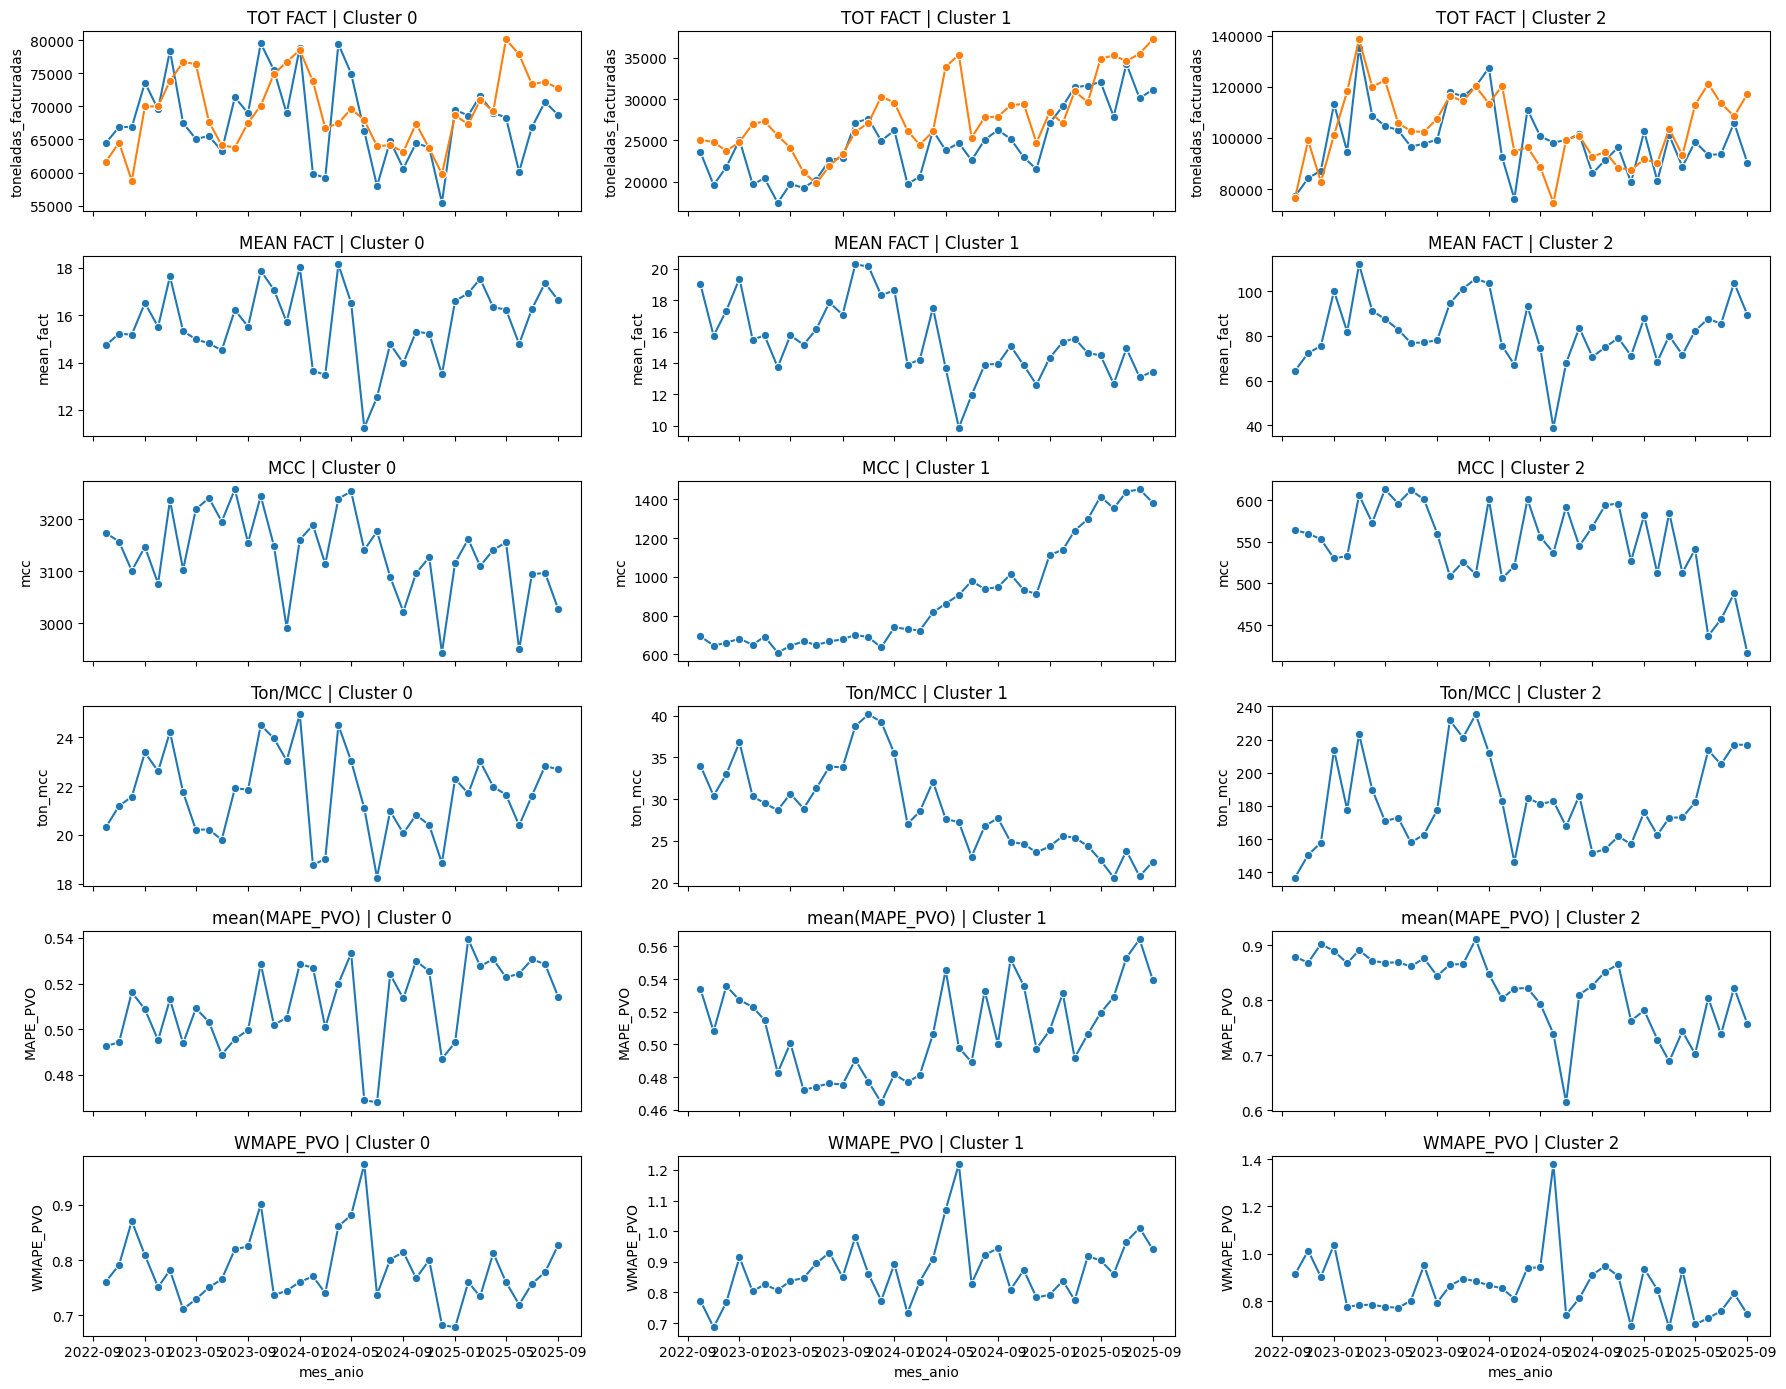

In [48]:
tab_analisis = analisis1.groupby(["Cluster", "mes_anio"]).agg({"toneladas_facturadas": ["sum", "mean"], "toneladas_pvo":["sum", "mean"],"mcc":"sum", "MAPE_PVO" : "mean", "WMAPE_PVO" : "sum"}).reset_index()

tab_analisis.columns = ["Cluster", "mes_anio", "toneladas_facturadas", "mean_fact","pvo_tot","pvo_mean", "mcc", "MAPE_PVO", "WMAPE_PVO"] 

tab_analisis["WMAPE_PVO"] = tab_analisis["WMAPE_PVO"].div(tab_analisis["toneladas_facturadas"])  

tab_analisis["ton_mcc"] = tab_analisis.toneladas_facturadas.div(tab_analisis.mcc) 

# Crear figura con 3 filas (KPIs) y 3 columnas (Clusters)
n = 3
fig, axes = plt.subplots(6, n, figsize=(18, 14), sharex=True)

# KPIs y títulos
kpis = ["toneladas_facturadas","mean_fact", "mcc", "ton_mcc", "MAPE_PVO", "WMAPE_PVO"]

kpi_titles = ["TOT FACT" ,"MEAN FACT","MCC", "Ton/MCC", "mean(MAPE_PVO)", "WMAPE_PVO"]

# Graficar cada KPI por cluster
for i, kpi in enumerate(kpis):

    for j in range(n):
        cluster_data = tab_analisis[tab_analisis["Cluster"] == j]
        
        if kpi =="toneladas_facturadas":  
            sns.lineplot(ax=axes[i, j], data=cluster_data.fillna(0), x="mes_anio", y="toneladas_facturadas", marker="o")
            sns.lineplot(ax=axes[i, j], data=cluster_data.fillna(0), x="mes_anio", y="pvo_tot", marker="o")
        else :
            sns.lineplot(ax=axes[i, j], data=cluster_data, x="mes_anio", y=kpi, marker="o")

        axes[i, j].set_title(f"{kpi_titles[i]} | Cluster {j}")
# 
plt.tight_layout()
plt.savefig("kpi_cluster_grid_extended.png")
print("Gráfico guardado como 'kpi_cluster_grid_extended.png'")

In [49]:
tabla_arbol

,id,NombreGrupo,nom_ubicacion,nom_articulo_2,nom_articulo,NombreGrupoEstadistico1,NombreGrupoEstadistico2,NombreGrupoEstadistico3,NombreGrupoEstadistico4,nom_familia_asociada,analisis,tiene_registros_suficientes,tiene_fact_6m,tiene_pronostico,tiene_deuda,msc,count_mcc,toneladas_plan_ventas,toneladas_pvo,toneladas_deuda_libre,toneladas_deuda_mes_resto,toneladas_deuda_mes_siguiente,ton_pv_mes_act,ton_pvo_mes_act,ton_fact_mes_act,ton_pv_mes_ant,ton_pvo_mes_ant,ton_fact_mes_ant,ton_pv_mes_6m,ton_pvo_mes_6m,ton_fact_mes_6m,ton_pv_mes_6m_std,ton_pvo_mes_6m_std,ton_fact_mes_6m_std,CLUSTER
0,ACERÍA CELAYA_G3_VARILLA 1,DEACERO SOLUTIONS,ACERÍA CELAYA,G3_VARILLA 1,"VARILLA DA- 506 G42 C5 1"" 9.0M P45 R INGETEK",VARILLA,VARILLA,VARILLA 1,VARILLA 1 RECTA,(57) VARILLA LAM CALIENTE,Datos Insuficientes/ Pedidos Intermitentes,False,False,False,False,33.0,1.0,NaN,NaN,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,ACERÍA CELAYA_G3_VARILLA 3/4,ALAMBRES,ACERÍA CELAYA,G3_VARILLA 3/4,"VARILLA DA- 506 G42 C5 3/4"" 12.0 M P41 R INGET...",VARILLA,VARILLA,VARILLA 3/4,VARILLLA 3/4 RECTA,(57) VARILLA LAM CALIENTE,Datos Insuficientes/ Pedidos Intermitentes,False,False,False,False,37.0,1.0,NaN,NaN,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,WEST MEMPHIS DC._G3_ANGULOS ESTRUCTURALES,USA,WEST MEMPHIS DC.,G3_ANGULOS ESTRUCTURALES,"ANGLE 5"" X 5"" X 5/16"" A36/529-50 20' 2.0T",PERFILES,PERFILES ESTRUCTURALES,ANGULOS ESTRUCTURALES,"ANGULO 5""",(236) ANGULO,Datos Insuficientes/ Pedidos Intermitentes,False,False,False,False,26.0,1.0,NaN,NaN,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
3,ACERÍA CELAYA_G3_VARILLA 1/2,ACEROS,ACERÍA CELAYA,G3_VARILLA 1/2,"VARILLA DA- 506 G42 C2 1/2"" 12.0 M P02 R",VARILLA,VARILLA,VARILLA 1/2,VARILLA 1/2 RECTA,(57) VARILLA LAM CALIENTE,Datos Insuficientes/ Pedidos Intermitentes,False,False,False,False,33.0,1.0,NaN,NaN,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.509807,2.691963,NaN,1.290545,1.60605,NaN,2.0
4,ACERÍA CELAYA_G3_VARILLA 1/2,ALAMBRES,ACERÍA CELAYA,G3_VARILLA 1/2,"VARILLA DA- 506 G42 C1 1/2"" 10.60 M P92 R",VARILLA,VARILLA,VARILLA 1/2,VARILLA 1/2 RECTA,(57) VARILLA LAM CALIENTE,Datos Insuficientes/ Pedidos Intermitentes,False,False,False,False,25.0,1.0,NaN,NaN,0.000000,0.0,0.0,NaN,NaN,NaN,0.39474,0.39474,0.0,0.394740,0.394740,NaN,NaN,NaN,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37514,UNIDADES DE SERVICIO_SKU_GRAPA NACIONAL (10 M)...,ALAMBRES,UNIDADES DE SERVICIO,"SKU_GRAPA NACIONAL (10 M) N 16 1 1/2""","GRAPA NACIONAL (10 M) N 16 1 1/2""",MALLAS Y ALAMBRES,INDUSTRIAL FASTENERS,GRAPA P/MADERA,GRAPA P/CASCO NACIONAL,(4900 - 2939) GRAPA P/CASCO GS CAL16 PASLODE,Datos Insuficientes/ Pedidos Intermitentes,False,False,True,False,60.0,0.0,0.00214,0.00214,0.000000,0.0,0.0,0.00214,0.00214,0.0,0.01231,0.01231,0.0,0.012310,0.012310,NaN,NaN,NaN,NaN,4.0
37515,UNIDADES DE SERVICIO_SKU_GRAPA NACIONAL DEACER...,ALAMBRES,UNIDADES DE SERVICIO,"SKU_GRAPA NACIONAL DEACERO GS 16 1 3/4""","GRAPA NACIONAL DEACERO GS 16 1 3/4""",MALLAS Y ALAMBRES,INDUSTRIAL FASTENERS,GRAPA P/MADERA,GRAPA P/CASCO NACIONAL,(4900 - 2939) GRAPA P/CASCO GS CAL16 PASLODE,Datos Insuficientes/ Pedidos Intermitentes,False,False,True,False,60.0,0.0,0.00303,0.00303,0.000000,0.0,0.0,0.00303,0.00303,0.0,0.01744,0.01744,0.0,0.017440,0.017440,NaN,NaN,NaN,NaN,4.0
37516,VIRTUAL AZZ SAN ANTONIO_G3_GALVANIZED FAB. BAR...,DEACERO SOLUTIONS,VIRTUAL AZZ SAN ANTONIO,G3_GALVANIZED FAB. BARS & BEAMS,"GALVANIZED SOLAR PIERS 6"" X 12.0 A992/572-50 1...",SOLUCIONES,PERFILES HABILITADOS,GALVANIZED FAB. BARS & BEAMS,GALVANIZED FABRICATED BEAMS,(499) PERFIL HABILITADO ITK,Datos Insuficientes/ Pedidos Intermitentes,False,False,False,True,60.0,0.0,0.00000,0.00000,35.380280,0.0,0.0,0.00000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
37517,VIRTUAL AZZ SAN ANTONIO_G3_GALVANIZED FAB. BAR...,DEACERO SOLUTIONS,VIR

In [50]:
tabla_arbol["dist_pv_pv6m"] = (tabla_arbol ["ton_pv_mes_act"].fillna(0) - tabla_arbol["ton_pv_mes_6m"].fillna(0)).abs()

tabla_arbol["dit_pv_fact6m"] = (tabla_arbol ["ton_pv_mes_act"].fillna(0) - tabla_arbol["ton_fact_mes_6m"].fillna(0)).abs()

tabla_arbol["ranking"] = tabla_arbol.groupby(["analisis", "CLUSTER"]).dit_pv_fact6m.rank(method = "dense", ascending=False)# Ranking por analisis &  Cluster?

tabla_arbol["DIST_PVO_TON6M_PP"] = (tabla_arbol ["ton_pv_mes_act"].fillna(0) - tabla_arbol["ton_pv_mes_6m"].fillna(0)) /tabla_arbol ["ton_pv_mes_act"].fillna(0)

tabla_arbol["cov_pv"] = tabla_arbol["ton_pv_mes_6m_std"].div(tabla_arbol["ton_pv_mes_6m"]).abs().clip(-3,3)
tabla_arbol["cov_fact"] = tabla_arbol["ton_fact_mes_6m_std"].div(tabla_arbol["ton_fact_mes_6m"]).abs().clip(0,3)

tabla_arbol.to_excel(r".\outputs\resultados_arbol.xlsx", index = False)

In [51]:
data["CLUSTER"] =  data["id"].map( analisis1.set_index("id").Cluster.to_dict()).fillna(4)

data["ANALISIS"] =  data["id"].map( tabla_arbol.set_index("id").analisis.to_dict()).fillna("SC")

#data.to_csv(r".\outputs\alertas_series.csv" ,index = False)

#tabla_arbol["ACTUALIZACION"] = date

#FUNCION QUE CONVIERTE LA LISTA DE LISTAS EN STRING  
def list_2_str(x):
    if type(x) == list :
        if len(x) == 1: 
            return x[0]
        else:
            return ",".join(x)
    else: 
        return None

#tabla_arbol["ANIO_6M_UNIQUE"] = tabla_arbol["ANIO_6M_UNIQUE"].apply(lambda  x: list_2_str(x))

#tabla_arbol.to_csv(r".\outputs\resultados_arbol.csv", index = False)

In [54]:
tabla_arbol["vaild_col"] = np.where(tabla_arbol.loc[:,tabla_arbol.columns[tabla_arbol.columns.str.contains("ton")]].fillna(0).sum(axis = 1) != 0 , True, False)
tabla_arbol = tabla_arbol[tabla_arbol["vaild_col"] == True]
tabla_arbol.drop(columns = "vaild_col", inplace = True)
tabla_arbol["pk"] = tabla_arbol[["NombreGrupo", "nom_ubicacion", "NombreGrupoEstadistico1", "NombreGrupoEstadistico2","NombreGrupoEstadistico3", "NombreGrupoEstadistico4","nom_articulo"]].apply(lambda x: "_".join(x), axis=1)
tabla_arbol.to_excel(r".\outputs\resultados_arbol.xlsx", index = False)

C:\Users\adojeda\AppData\Local\Temp\ipykernel_19120\2763091427.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tabla_arbol["vaild_col"] = np.where(tabla_arbol.loc[:,tabla_arbol.columns[tabla_arbol.columns.str.contains("ton")]].fillna(0).sum(axis = 1) != 0 , True, False)


In [55]:
tabla_arbol

,id,NombreGrupo,nom_ubicacion,nom_articulo_2,nom_articulo,NombreGrupoEstadistico1,NombreGrupoEstadistico2,NombreGrupoEstadistico3,NombreGrupoEstadistico4,nom_familia_asociada,analisis,tiene_registros_suficientes,tiene_fact_6m,tiene_pronostico,tiene_deuda,msc,count_mcc,toneladas_plan_ventas,toneladas_pvo,toneladas_deuda_libre,toneladas_deuda_mes_resto,toneladas_deuda_mes_siguiente,ton_pv_mes_act,ton_pvo_mes_act,ton_fact_mes_act,ton_pv_mes_ant,ton_pvo_mes_ant,ton_fact_mes_ant,ton_pv_mes_6m,ton_pvo_mes_6m,ton_fact_mes_6m,ton_pv_mes_6m_std,ton_pvo_mes_6m_std,ton_fact_mes_6m_std,CLUSTER,dist_pv_pv6m,dit_pv_fact6m,ranking,DIST_PVO_TON6M_PP,cov_pv,cov_fact,pk
3,ACERÍA CELAYA_G3_VARILLA 1/2,ACEROS,ACERÍA CELAYA,G3_VARILLA 1/2,"VARILLA DA- 506 G42 C2 1/2"" 12.0 M P02 R",VARILLA,VARILLA,VARILLA 1/2,VARILLA 1/2 RECTA,(57) VARILLA LAM CALIENTE,Datos Insuficientes/ Pedidos Intermitentes,False,False,False,False,33.0,1.0,NaN,NaN,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.509807,2.691963,NaN,1.290545,1.60605,NaN,2.0,2.509807,0.00000,254.0,-inf,0.514201,NaN,ACEROS_ACERÍA CELAYA_VARILLA_VARILLA _VARILLA ...
4,ACERÍA CELAYA_G3_VARILLA 1/2,ALAMBRES,ACERÍA CELAYA,G3_VARILLA 1/2,"VARILLA DA- 506 G42 C1 1/2"" 10.60 M P92 R",VARILLA,VARILLA,VARILLA 1/2,VARILLA 1/2 RECTA,(57) VARILLA LAM CALIENTE,Datos Insuficientes/ Pedidos Intermitentes,False,False,False,False,25.0,1.0,NaN,NaN,0.000000,0.0,0.0,NaN,NaN,NaN,0.39474,0.39474,0.0,0.394740,0.394740,NaN,NaN,NaN,NaN,2.0,0.394740,0.00000,254.0,-inf,NaN,NaN,ALAMBRES_ACERÍA CELAYA_VARILLA_VARILLA _VARILL...
5,ACERÍA CELAYA_G3_VARILLA 1/2,ALAMBRES,ACERÍA CELAYA,G3_VARILLA 1/2,"VARILLA DA- 506 G42 C1 1/2"" 9.0M P25 R",VARILLA,VARILLA,VARILLA 1/2,VARILLA 1/2 RECTA,(57) VARILLA LAM CALIENTE,Datos Insuficientes/ Pedidos Intermitentes,False,False,False,False,25.0,1.0,NaN,NaN,0.000000,0.0,0.0,NaN,NaN,NaN,0.19737,0.19737,0.0,0.197370,0.197370,NaN,NaN,NaN,NaN,2.0,0.197370,0.00000,254.0,-inf,NaN,NaN,ALAMBRES_ACERÍA CELAYA_VARILLA_VARILLA _VARILL...
8,ACERÍA CELAYA_G3_ANGULOS ESTRUCTURALES,ACEROS,ACERÍA CELAYA,G3_ANGULOS ESTRUCTURALES,"ANGULO LI 3"" X 3"" X 1/4"" A-36 6.10M 2.0T",PERFILES,PERFILES ESTRUCTURALES,ANGULOS ESTRUCTURALES,"ANGULO 3""",(236) ANGULO,Datos Insuficientes/ Pedidos Intermitentes,False,False,False,False,17.0,1.0,NaN,NaN,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.661760,1.661760,NaN,NaN,NaN,NaN,4.0,1.661760,0.00000,4232.0,-inf,NaN,NaN,ACEROS_ACERÍA CELAYA_PERFILES_PERFILES ESTRUCT...
9,ACERÍA CELAYA_G3_ANGULOS ESTRUCTURALES,ACEROS,ACERÍA CELAYA,G3_ANGULOS ESTRUCTURALES,"ANGULO LI 3"" X 3"" X 3/8"" A-36 6.10M 2.0T",PERFILES,PERFILES ESTRUCTURALES,ANGULOS ESTRUCTURALES,"ANGULO 3""",(236) ANGULO,Datos Insuficientes/ Pedidos Intermitentes,False,False,False,False,17.0,1.0,NaN,NaN,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.127880,1.127880,NaN,NaN,NaN,NaN,4.0,1.127880,0.00000,4232.0,-inf,NaN,NaN,ACEROS_ACERÍA CELAYA_PERFILES_PERFILES ESTRUCT...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37514,UNIDADES DE SERVICIO_SKU_GRAPA NACIONAL (10 M)...,ALAMBRES,UNIDADES DE SERVICIO,"SKU_GRAPA NACIONAL (10 M) N 16 1 1/2""","GRAPA NACIONAL (10 M) N 16 1 1/2""",MALLAS Y ALAMBRES,INDUSTRIAL FASTENERS,GRAPA P/MADERA,GRAPA P/CASCO NACIONAL,(4900 - 2939) GRAPA P/CASCO GS CAL16 PASLODE,Datos Insuficientes/ Pedidos Intermitentes,False,False,True,False,60.0,0.0,0.00214,0.00214,0.000000,0.0,0.0,0.00214,0.00214,0.0,0.01231,0.01231,0.0,0.012310,0.012310,NaN,NaN,NaN,NaN,4.0,0.010170,0.00214,4092.0,-4.752336,NaN,NaN,ALAMBRES_UNIDADES DE SERVICIO_MALLAS Y ALAMBRE...
37515,UNIDADES DE SERVICIO_SKU_GRAPA NACIONAL DEACER...,ALAMBRES,UNIDADES DE SERVICIO,"SKU_GRAPA NACIONAL DEACERO GS 16 1 3/4""","GRAPA NACIONAL DEACERO GS 16 1 3/4""",MALLAS Y ALAMBRES,INDUSTRIAL FASTENERS,GRAPA P/MADERA,GRAPA P/CASCO NACIONAL,(4900 - 2939) GRAPA P/CASCO GS CAL16 PASLODE,Datos Insuficientes/ Pedidos Intermitentes,False,False,Tru

# subir información a BQ

In [56]:
from pandas_gbq import to_gbq

# Parámetros
project_id = "common-prj-sandbox"
dataset_id = "Dev_AldoOjeda"
table_name = "dev_alertas_sku_pl"
full_table_id = f"{dataset_id}.{table_name}"


# Subir el DataFrame
to_gbq(tabla_arbol, full_table_id, project_id=project_id, if_exists="replace")

100%|██████████| 1/1 [00:00<?, ?it/s]


# FALTA DESARROLLO DEL DASHBOARD
 AGREGAR INFORMACION HISTORICA CON ALERTAS/SKU

Participación de volumen por ubicación
Cantidad de PL con volumen: 177


<Axes: title={'center': '% de Toneladas Facturadas por Ubicación'}, ylabel='nom_ubicacion'>

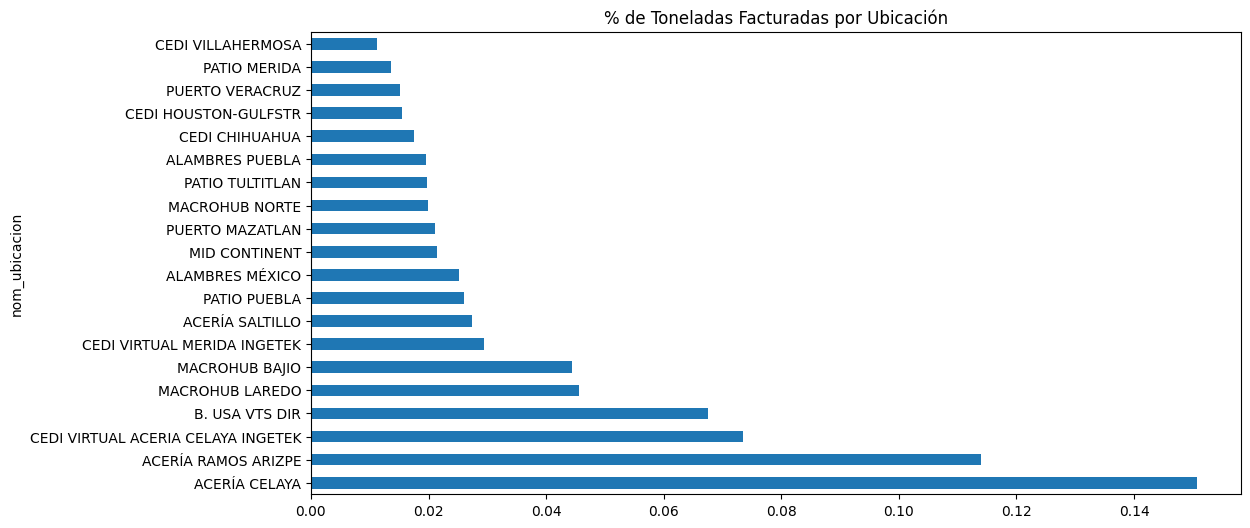

In [89]:
print("Participación de volumen por ubicación")

print("Cantidad de PL con volumen: {}".format(data_.nom_ubicacion.nunique()))

data.groupby("nom_ubicacion").toneladas_facturadas.sum().div(data_.toneladas_facturadas.sum()).sort_values(ascending=False).head(20).plot(kind='barh', figsize=(12, 6), title='% de Toneladas Facturadas por Ubicación')

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import hashlib
from datetime import datetime

# ------------------------------------------------------
date = datetime.now().date()
# ------------------------------------------------------
m, y = date.month, date.year
# ------------------------------------------------------
min_date = date.replace(year= y-1, month = m, day = 1)

min_date_2 = date.replace(year= y-2, month = m, day = 1)

max_date = date.replace( month = m-1, day = 1)

actual_date = date.replace(day = 1)

min_date, max_date, actual_date

(datetime.date(2024, 10, 1),
 datetime.date(2025, 9, 1),
 datetime.date(2025, 10, 1))

In [92]:
var= "toneladas_plan_ventas"

var2del = "toneladas_pvo"

pvo = pd.read_csv(r".\consultas\pvo.csv", engine="pyarrow")

pvo.nom_familia_asociada = pvo.nom_familia_asociada.str.replace(r'\s+|\t+', ' ', regex=True)

pvo.nom_ubicacion = pvo.nom_ubicacion.str.replace(r'\s+|\t+', ' ', regex=True)

pvo["Base"] = "pvo"

pvo = pvo.drop(columns= ["toneladas_dim_capacidades", var2del]) #"toneladas_pvo"

print(pvo.shape)

pvo = pvo.dropna(subset = [var, "nom_articulo", "nom_ubicacion"], how="any")

print(pvo.shape)

pvo["MesAct_fact"] = False

(1210784, 13)
(128244, 13)


<Axes: xlabel='MesAnio'>

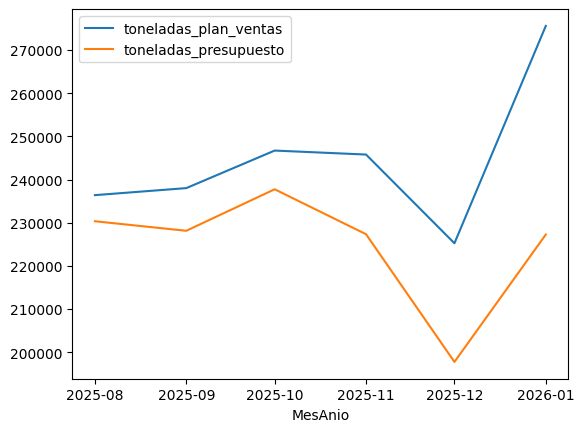

In [93]:
pvo.groupby("MesAnio").agg({"toneladas_plan_ventas":"sum", "toneladas_presupuesto" :"sum"}).plot()

In [94]:
fact = pd.read_csv(r".\consultas\fact.csv", engine="pyarrow")

fact.nom_familia_asociada = fact.nom_familia_asociada.str.replace(r'\s+|\t+', ' ', regex=True)

fact.nom_ubicacion = fact.nom_ubicacion.str.replace(r'\s+|\t+', ' ', regex=True)

fact["Base"] = "fact"

fact = fact[(fact.MesAnio >= min_date_2) & (fact.MesAnio >= min_date_2) ]

fact["MesAct_fact"] = np.where( fact.MesAnio == actual_date, True, False)

fact.nom_familia_asociada = np.where(fact.nom_familia_asociada.isna(), fact.nom_articulo, fact.nom_familia_asociada) 

fact.MesAnio.nunique()

20

In [162]:
x

,mes_anio,toneladas_facturadas,toneladas_deuda_libre,toneladas_deuda_mes_resto,toneladas_deuda_mes_siguiente,toneladas_plan_ventas,toneladas_pvo,MAPE_PVO,WMAPE_PVO,Año,Mes
0,2022-09-01,250522.458530,0.000000,0.000000,0.000000,240372.174000,242070.59000,7608.690596,212601.491934,2022,9
1,2022-10-01,240092.849048,0.000000,0.000000,0.000000,256588.738000,257598.18100,7560.365231,191964.405189,2022,10
2,2022-11-01,264161.711156,0.000000,0.000000,0.000000,293740.965000,295699.06500,7529.344271,220563.353228,2022,11
3,2022-12-01,261270.608146,0.000000,0.000000,0.000000,273995.597000,260147.87900,7570.172464,212562.011876,2022,12
4,2023-01-01,313430.618742,0.000000,0.000000,0.000000,312528.141000,298882.43117,7543.366225,269343.468691,2023,1
5,2023-02-01,282863.453461,0.000000,0.000000,0.000000,324150.797240,315952.64114,7517.291982,213272.473003,2023,2
6,2023-03-01,331272.298213,0.000000,0.000000,0.000000,336808.929160,334046.90759,8025.935110,261380.037897,2023,3
7,2023-04-01,269785.404762,0.000000,0.000000,0.000000,340532.613710,320518.66467,7645.491625,200245.881452,2023,4
8,2023-05-01,254641.377198,0.000000,0.000000,0.000000,299670.119180,302276.42556,7686.133090,197222.117795,2023,5
9,2023-06-01,252783.123758,0.000000,0.000000,0.000000,297406.499390,274738.17080,7879.907324,192407.737814,2023,6


C:\Users\adojeda\AppData\Local\Temp\ipykernel_2884\2220778978.py:36: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result_d = kpss(detrend_serie.dropna(), regression='c')
c:\Users\adojeda\OneDrive - deacero.com\dev\0_envs\.bigquery\Lib\site-packages\statsmodels\tsa\filters\hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


Resultados de pruebas estadísticas:

ADF p-value: 0.0271 (H0: no estacionaria)
KPSS p-value: 0.0174 (H0: estacionaria)
Ljung-Box p-value: 0.0001 (H0: no autocorrelación)
ADF p-value: 0.0000 (H0: no estacionaria)
KPSS p-value: 0.1000 (H0: estacionaria)
Ljung-Box p-value: 0.0657 (H0: no autocorrelación)
Chow Test p-value: 0.3896 (H0: sin ruptura estructural)


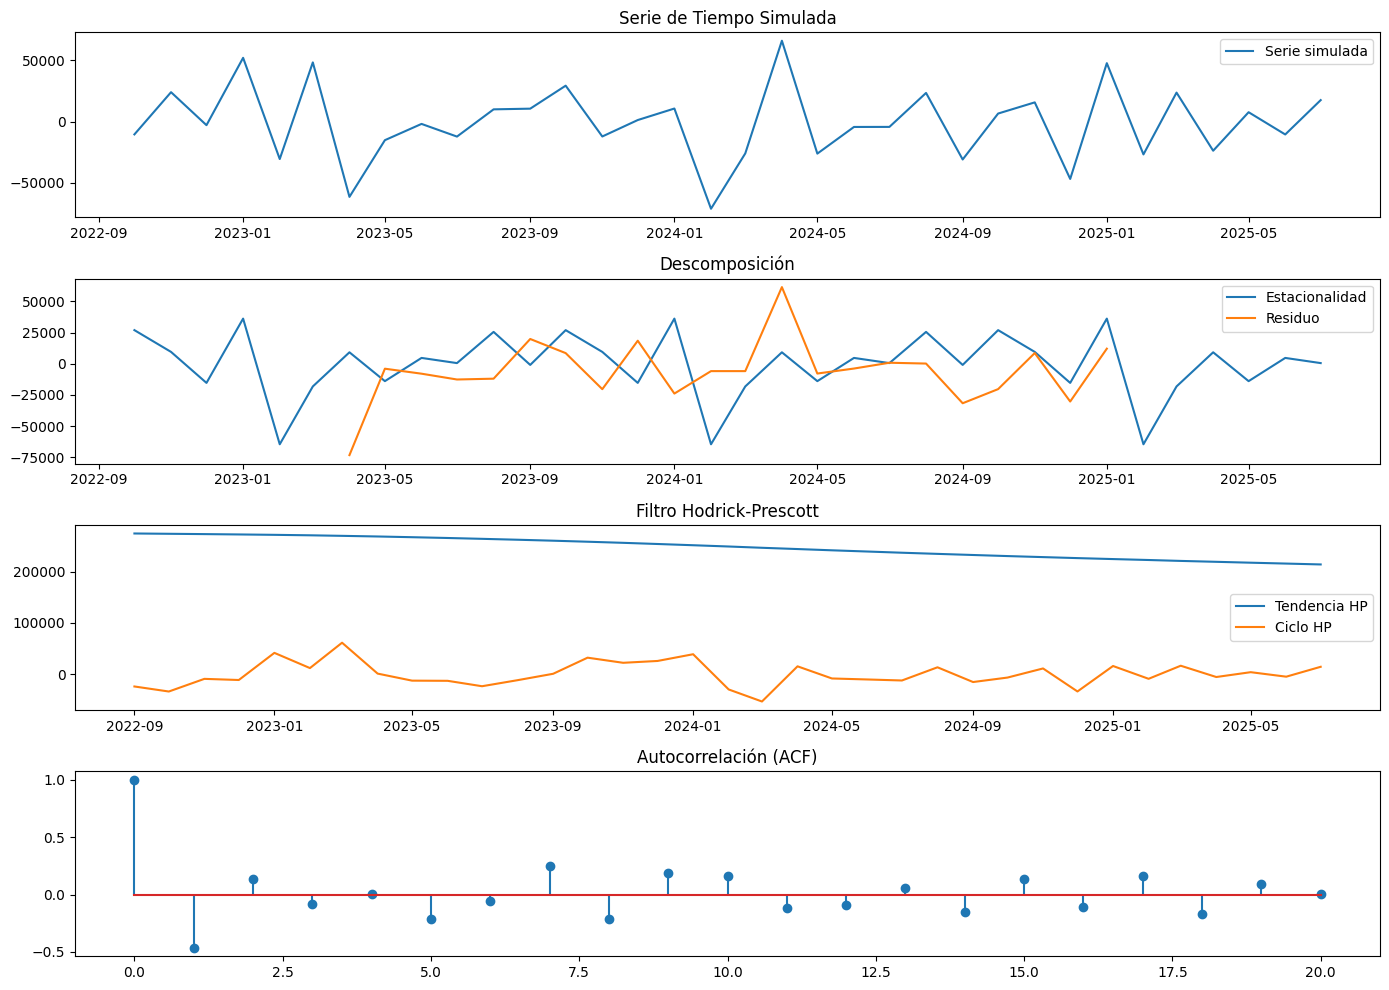

In [366]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from scipy.stats import norm

# Simular datos de series de tiempo con varios comportamientos
np.random.seed(42)
periods = 35
trend = np.linspace(10, 50, periods)
seasonality = 10 * np.sin(np.linspace(0, 3 * np.pi, periods))
noise = np.random.normal(0, 2, periods)
structural_break = np.array([5 if i > 60 else 0 for i in range(periods)])

data = trend + seasonality + noise + structural_break
tf = x.set_index("mes_anio").toneladas_facturadas[:35]

dates = tf.index
series = tf
detrend_serie = (series - series.shift(1)).dropna()
 

# Descomposición de la serie
decomposition = seasonal_decompose(detrend_serie, model='additive')

# Pruebas estadísticas
adf_result = adfuller(series)
adf_result_d = adfuller(detrend_serie.dropna())
kpss_result = kpss(series, regression='c')
kpss_result_d = kpss(detrend_serie.dropna(), regression='c')
ljung_box_result = acorr_ljungbox(series, lags=[12], return_df=True)
ljung_box_result_d = acorr_ljungbox(detrend_serie, lags=[12], return_df=True)

# Filtro HP para detectar ciclos
cycle, trend_hp = hpfilter(series, lamb=1600)

# Chow Test simulado: comparar regresión antes y después del punto de quiebre
break_point = 15
X1 = add_constant(np.arange(break_point))
X2 = add_constant(np.arange(periods - break_point - 1))
model1 = OLS(detrend_serie[:break_point], X1).fit()
model2 = OLS(detrend_serie[break_point:], X2).fit()
RSS1 = sum(model1.resid ** 2)
RSS2 = sum(model2.resid ** 2)
RSS_combined = sum(OLS(detrend_serie, add_constant(np.arange(periods-1))).fit().resid ** 2)
k = 2  # número de parámetros
chow_stat = ((RSS_combined - (RSS1 + RSS2)) / k) / ((RSS1 + RSS2) / (periods - 2 * k))
p_value_chow = 1 - norm.cdf(chow_stat)

# Visualizaciones
plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(detrend_serie, label='Serie simulada')
plt.title('Serie de Tiempo Simulada')
plt.legend()

plt.subplot(412)
#plt.plot(decomposition.trend, label='Tendencia')
plt.plot(decomposition.seasonal, label='Estacionalidad')
plt.plot(decomposition.resid, label='Residuo')
plt.title('Descomposición')
plt.legend()

plt.subplot(413)
plt.plot(trend_hp, label='Tendencia HP')
plt.plot(cycle, label='Ciclo HP')
plt.title('Filtro Hodrick-Prescott')
plt.legend()

plt.subplot(414)
plt.stem(acf(detrend_serie, nlags=20))
plt.title('Autocorrelación (ACF)')

plt.tight_layout()
plt.savefig("temporal_analysis_notebook.png")

# Resultados de pruebas
print("Resultados de pruebas estadísticas:\n")
print(f"ADF p-value: {adf_result[1]:.4f} (H0: no estacionaria)")
print(f"KPSS p-value: {kpss_result[1]:.4f} (H0: estacionaria)")
print(f"Ljung-Box p-value: {ljung_box_result.iloc[0, 1]:.4f} (H0: no autocorrelación)")

print(f"ADF p-value: {adf_result_d[1]:.4f} (H0: no estacionaria)")
print(f"KPSS p-value: {kpss_result_d[1]:.4f} (H0: estacionaria)")
print(f"Ljung-Box p-value: {ljung_box_result_d.iloc[0, 1]:.4f} (H0: no autocorrelación)")

print(f"Chow Test p-value: {p_value_chow:.4f} (H0: sin ruptura estructural)")

# Estadistica Descriptiva PL

Con este análisis se busca contestar a las siguientes preguntas: 
* Existen PL parecidos?

In [ ]:
# Estadistica Descriptiva PL

data_[data_.mes_anio <= "2024-09-01" ].groupby(["nom_ubicacion","mes_anio", "nom_grupo"]).agg({"toneladas_facturadas":"sum","nom_articulo":"nunique"})

#data_




toneladas_facturadas  nom_articulo
nom_ubicacion     mes_anio                                      
3PL COATZACOALCOS 2022-09-01               0.00000             1
                  2022-12-01              88.26000             1
                  2023-01-01             385.59000             2
                  2023-02-01             476.08000             3
                  2023-03-01            1660.85000             4
...                                            ...           ...
WEST MEMPHIS DC.  2024-05-01             126.55600            80
                  2024-06-01             315.99220           160
                  2024-07-01              62.85436           111
                  2024-08-01             852.65200           109
                  2024-09-01             100.97156           112

[3075 rows x 2 columns]